# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
import seaborn as sns
import collections

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata
import src.genre_graph as genre_graph

In [2]:
(movies,people,list_of_genres_id) = ldata.load_dataframes();

2019-01-17 11:35:39,805 | INFO : Data loaded !


In [3]:
movies.head(1)

budget  genres                     homepage  id  \
0  237000000       0  http://www.avatarmovie.com/   0   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies   ...     \
0  150.437577  [{'name': 'Ingenious Film Partners', 'id': 289...   ...      

  runtime                                   spoken_languages    status  \
0   162.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   

                       tagline   title vote_average vote_count genres_names  \
0  Enter the World of Pandora.  Avatar          7.2      11800       Action   

         ROI  success  
0  10.763566      1.0  

[1 rows x 23 columns]

In [4]:
people.head(1)

cast_id   character                 credit_id  gender     id  movie_id  \
0    242.0  Jake Sully  5602a8a7c3a3685532001c9a       2  65731         0   

              name  order  type department  job  
0  Sam Worthington      0  cast        NaN  NaN

In [5]:
#Used to create a new feature matrix that contains only the actors (not the crew)
#features_actors=ldata.create_features(movies,people);

In [6]:
#a=movies['ROI'].sort_values()
#print(a.to_string())
filter_ROI=movies['ROI'].copy()
filter_ROI[filter_ROI>10]=10
movies['ROI']=filter_ROI
#Il faut filtrer les valeurs extremes du ROI (en enlevant celles au dessus de 10 ou de 100?), sinon les graphs et les heatmaps ne montrent rien

In [7]:
count_ROI=movies['ROI'].copy()
count_ROI.isna().sum()

0

In [8]:
#the list that makes the conversion between numerical values and genres titles
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

genres_names
genres                 
0                Action
1             Adventure
2               Fantasy
3             Animation
4       Science Fiction
5                 Drama
6              Thriller
7                Family
8                Comedy
9               History
10                  War
11              Western
12              Romance
13                Crime
14              Mystery
15               Horror
17                Music
16          Documentary
19              Unknown
20              Foreign

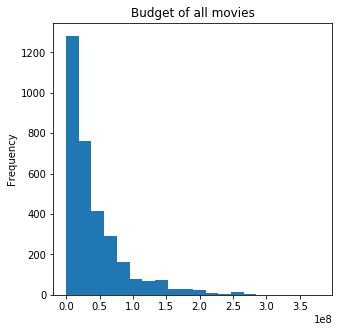

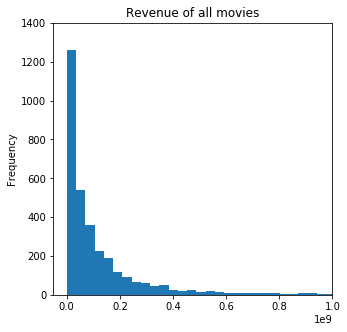

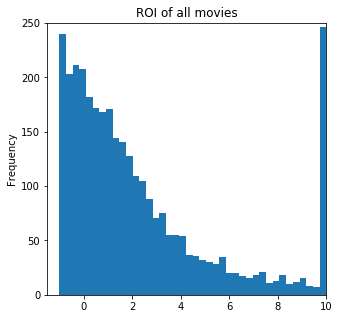

In [9]:
fig=plt.figure(figsize = (5,5))
movies.budget.plot(kind='hist', bins = 20)
plt.title('Budget of all movies')
plt.show()
fig.savefig('./pictures/budgets.png')

fig2=plt.figure(figsize = (5,5))
movies.revenue.plot(kind='hist', bins = 80)
plt.title('Revenue of all movies')
plt.axis([-0.05e9,1e9,0,1400])
plt.show()
fig2.savefig('./pictures/revenue.png')

fig3=plt.figure(figsize = (5,5))
movies.ROI.plot(kind='hist', bins = 40)
plt.title('ROI of all movies')
plt.axis([-1.5,10,0,250])
plt.show()
fig3.savefig('./pictures/roi.png')



In [10]:
data=movies['genres_names'].value_counts()
data

Drama              747
Comedy             634
Action             588
Adventure          288
Horror             197
Crime              141
Thriller           118
Animation           99
Fantasy             93
Science Fiction     79
Romance             70
Family              38
Documentary         30
Mystery             27
Western             22
Music               20
History             18
War                 18
Unknown              1
Foreign              1
Name: genres_names, dtype: int64

/home/jeremy/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


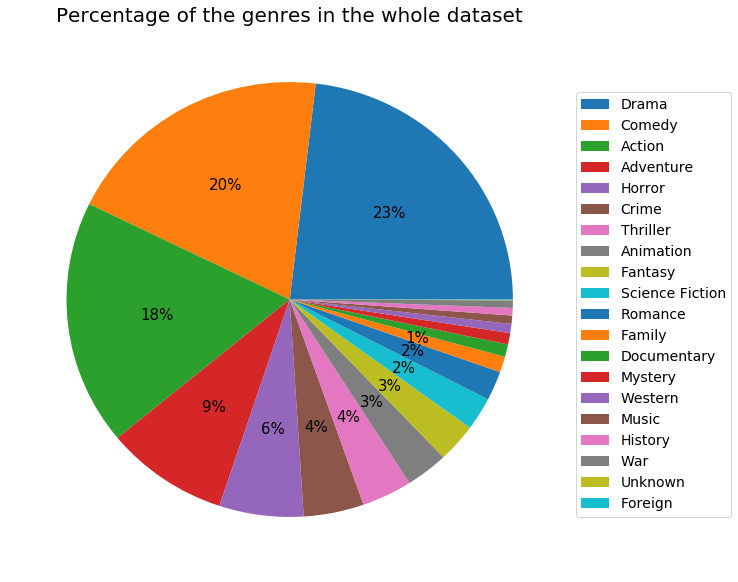

In [11]:
fig=plt.figure(figsize = (10,10))
plt.pie(data, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(data,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()
fig.savefig('./pictures/pie.png')

In [12]:
#CODE TO GENERATE THE ADJACENCY MATRIX THAT CONNECTES MOVIES TOGETHER
#TAKE A LONG AMOUNT OF TIME, SO JUST USE adjacency_test=np.load('./data/adjacency_test_movies.npy')

#features_movies=ldata.load_features();
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)
#np.save('./data/adjacency_actors_crew', adjacency_test);
#adjacency_test

#The commented lines can be replaced by the line below --> the creation of the adjacency doesn't have to be done each time.
#adjacency_test=np.load('./data/adjacency_actors_only.npy')

#need to find a way to select only certain movies from the features ()

893


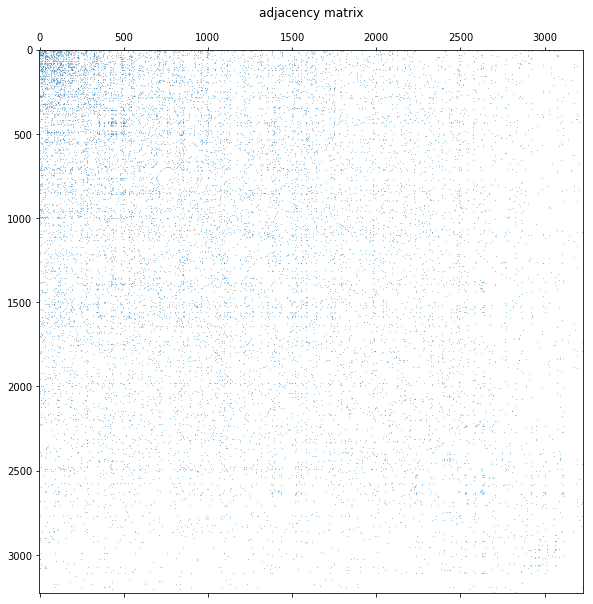

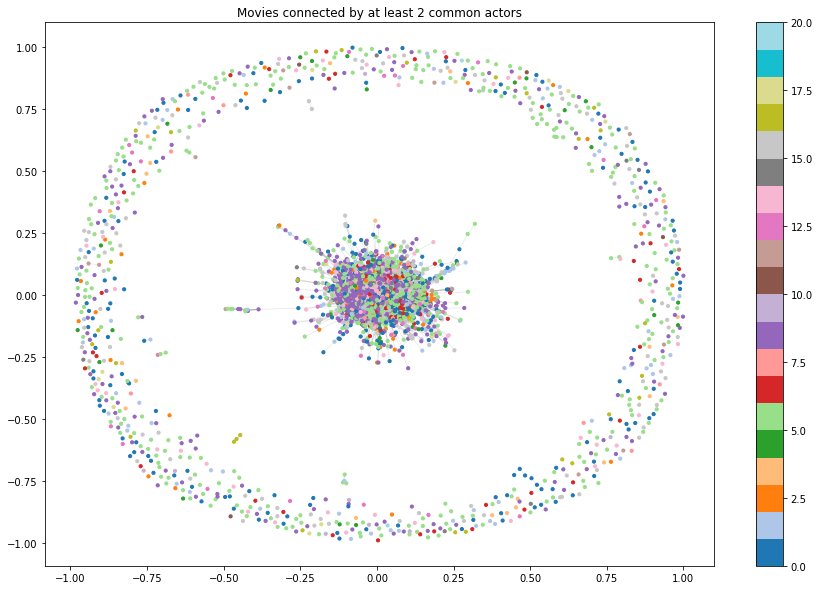

In [13]:
#adjacency using only the actors, not the crew

#LE CHOIX DE LA MATRICE EST IMPORTANTE, SURTOUT POUR LES DECADE AVEC PEU DE FILMS
#soit on utilise la version avec que des acteurs, soit la version avec acteurs et crew
adjacency_actors=np.load('./data/adjacency_actors_only.npy')
#adjacency_actors=np.load('./data/adjacency_actors_crew.npy')


#ON PEUT AUSSI AUGMENTER LE NOMBRE D'ACTEURS EN COMMUN NECESSAIRES
#adjacency_actors[adjacency_actors <2]=0

plt.figure(figsize=(10, 10))
plt.spy(adjacency_actors, markersize=0.1)
plt.title('adjacency matrix')

G_test = nx.from_numpy_matrix(adjacency_actors)
print(nx.number_connected_components(G_test))
coords_test = nx.spring_layout(G_test,k=0.03)  # Force-directed layout.
labels = movies['genres'].iloc[np.sort(nx.nodes(G_test))]

fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_test, coords_test, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(G_test, coords_test, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

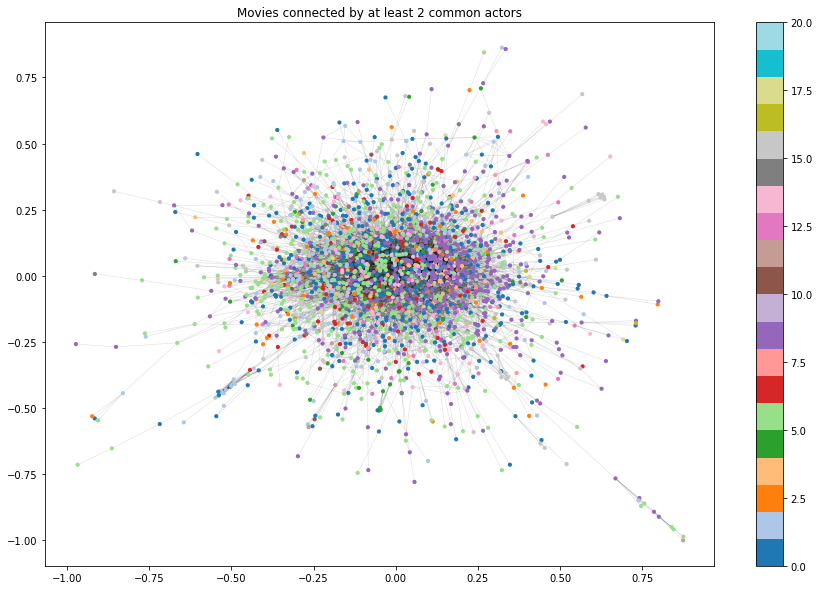

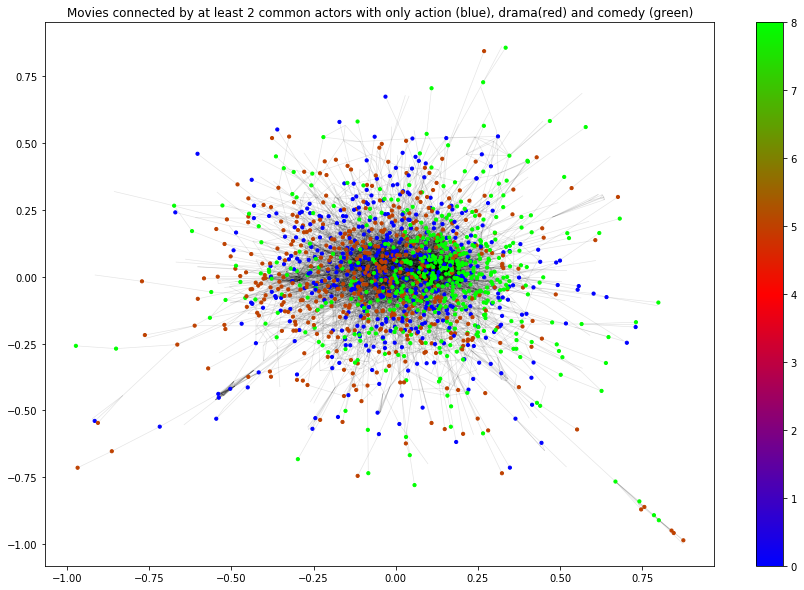

In [14]:
Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
coords_test = nx.spring_layout(Gc_test,k=0.03)  # Force-directed layout.
n_nodesGc=Gc_test.number_of_nodes()
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc_test))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

#Je n'arrive pas à masquer proprement les labels qui ne sont pas 0,5 ou 8 :(
masked_labels=labels.copy()
masked_labels[masked_labels<30]=30
masked_labels[labels==0]=0
masked_labels[labels==5]=5
masked_labels[labels==8]=8
masked_labels[masked_labels>10]=np.nan


#action=0=dark blue
#comedy=8=purple
#drama=5=light green

fig2=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=masked_labels, cmap='brg',vmin=0, vmax=8)
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors with only action (blue), drama(red) and comedy (green)')
plt.colorbar(im);
fig2.savefig('./pictures/graph2.png')


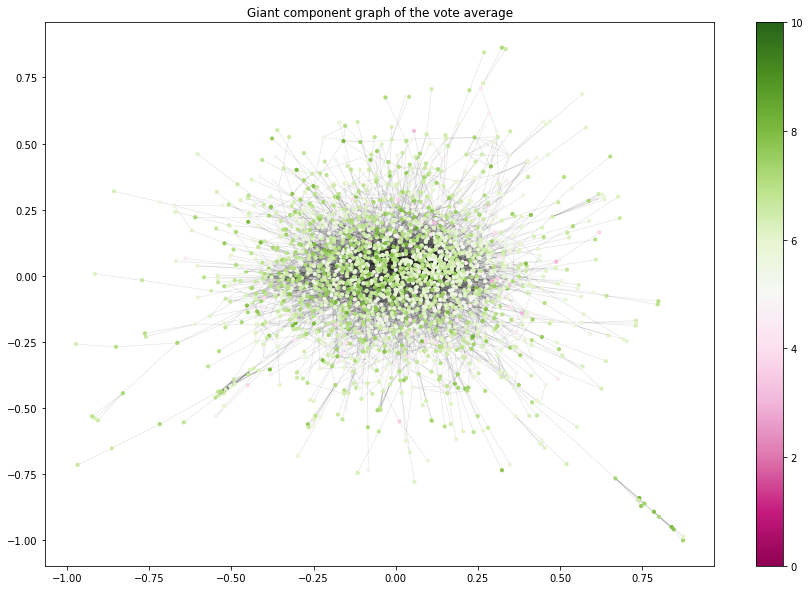

In [15]:
labels = movies['vote_average'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='PiYG',vmin=0, vmax=10)
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of the vote average')
plt.colorbar(im);

In [16]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

number of edges: 56555.0


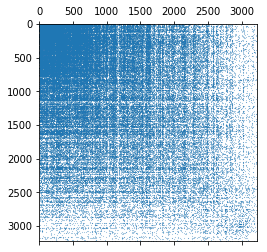

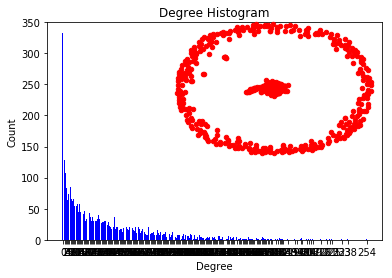

In [17]:
adjacency=np.load('./data/adjacency_actors_crew.npy')
plt.spy(adjacency, markersize=0.1)
n_edges =  np.count_nonzero(adjacency)/2
print('number of edges: {}'.format(n_edges))

G=nx.from_numpy_matrix(adjacency)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

7468.0


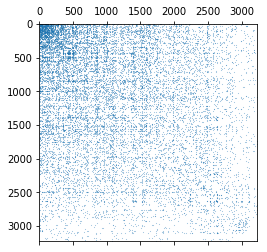

In [18]:
adjacency=np.load('./data/adjacency_actors_only.npy')
plt.spy(adjacency, markersize=0.1)
n_edges =  np.count_nonzero(adjacency)/2
print(n_edges)

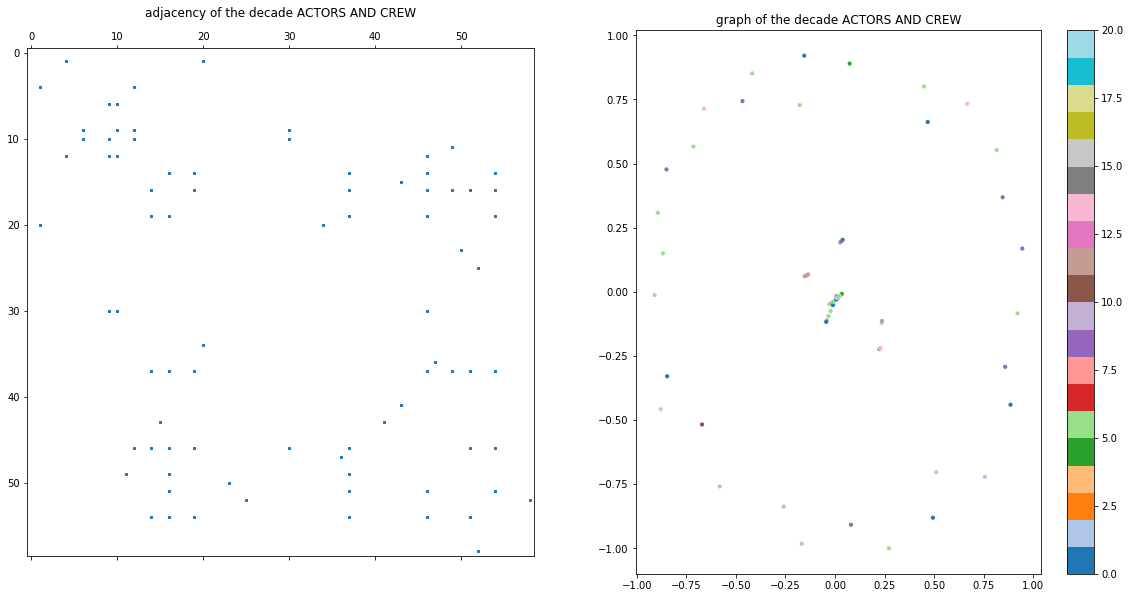

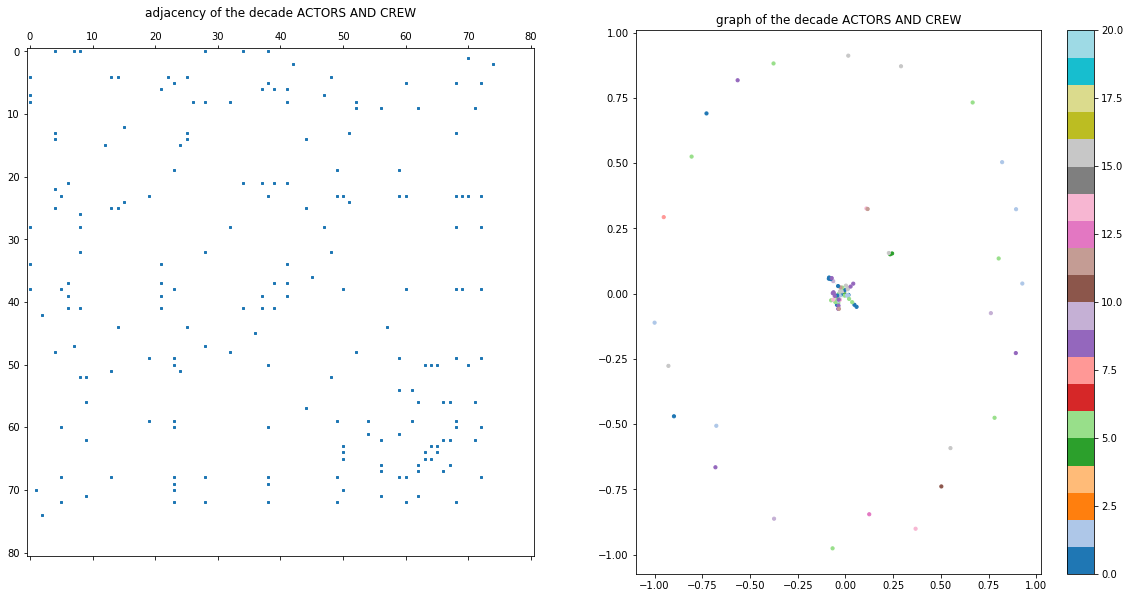

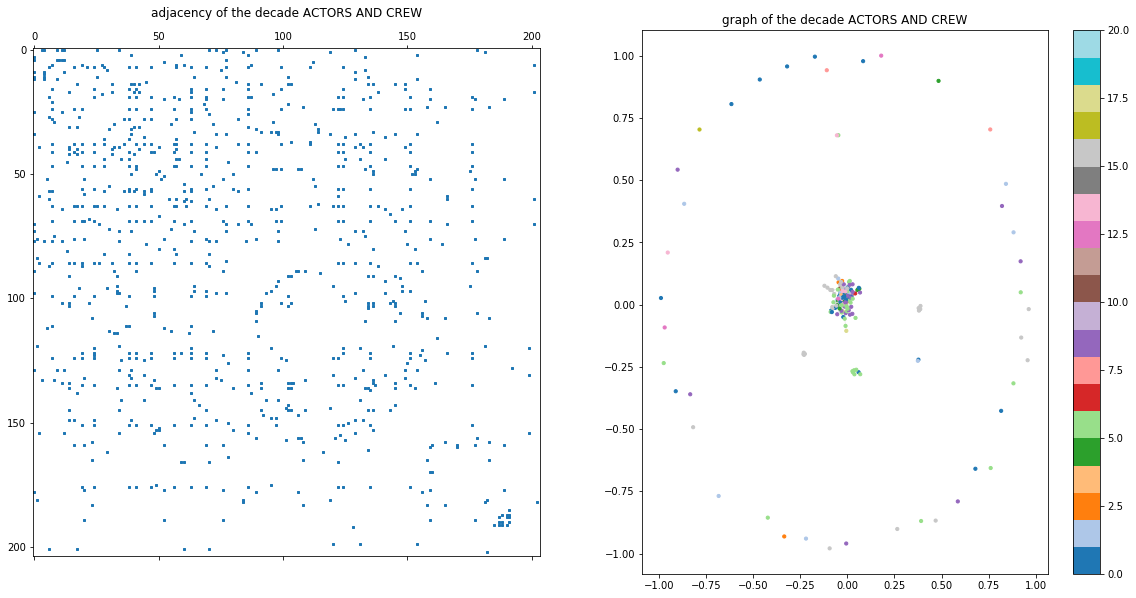

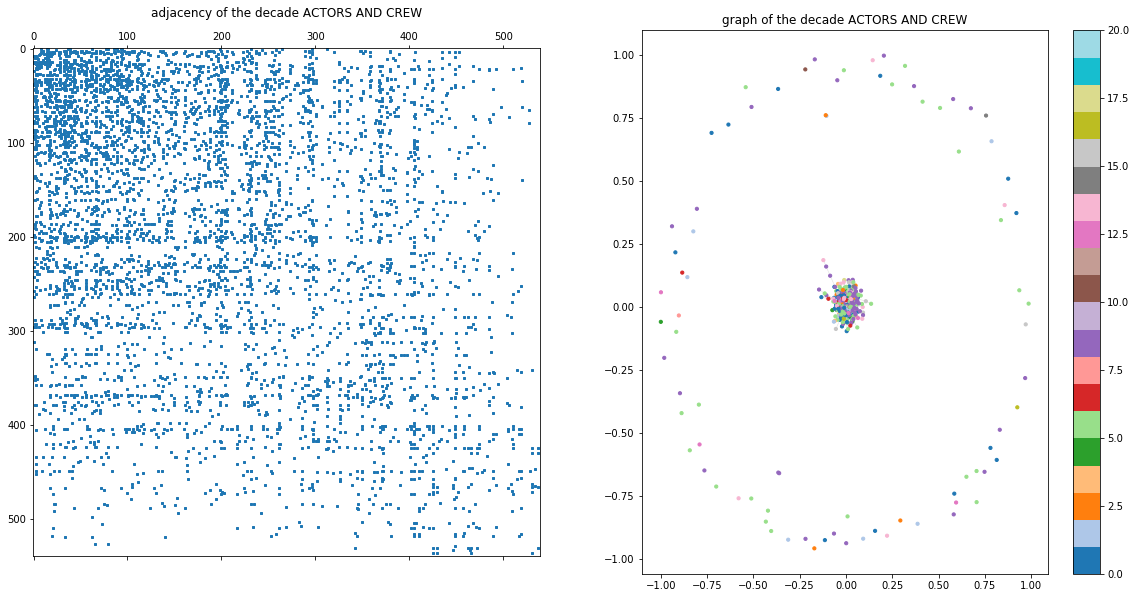

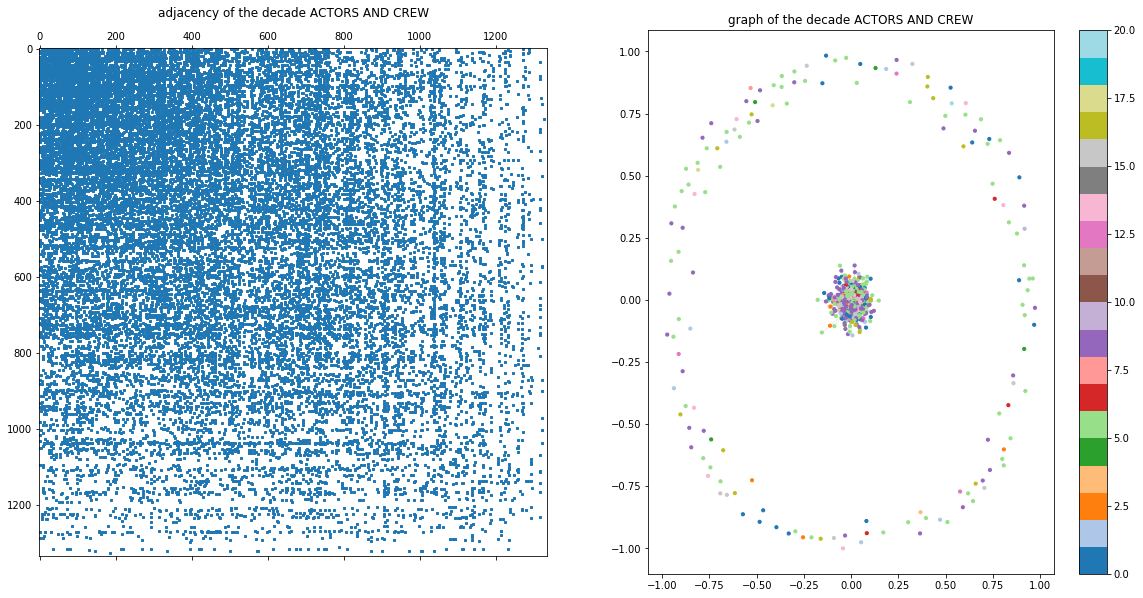

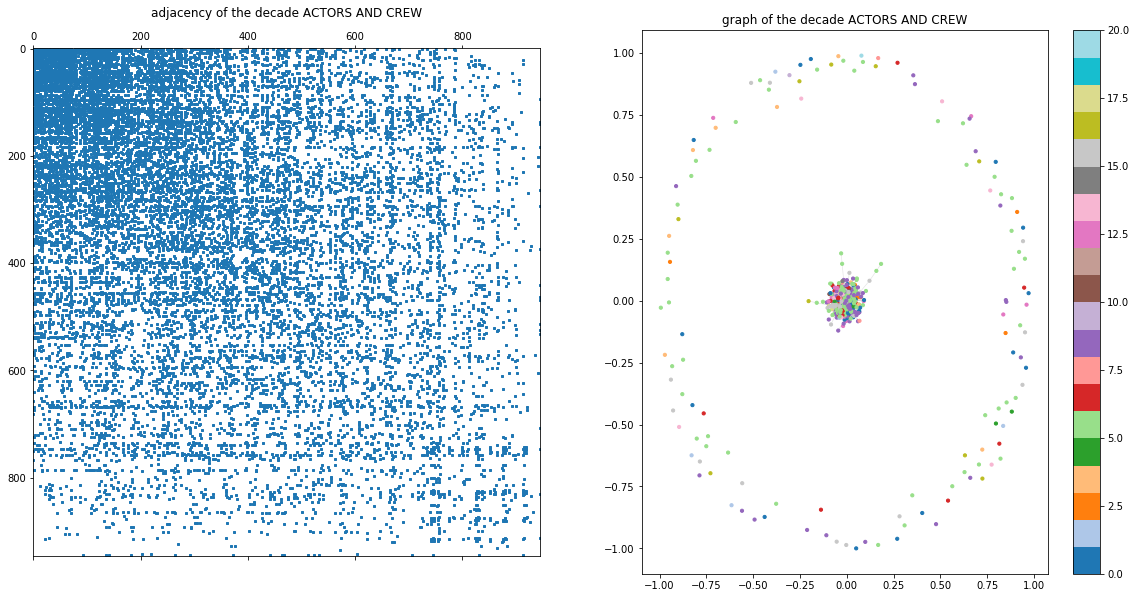

In [19]:
#Ici on fait le graph des films liés par les acteurs ET LE CREW
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency=np.load('./data/adjacency_actors_crew.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS AND CREW')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS AND CREW')
    plt.colorbar(im);

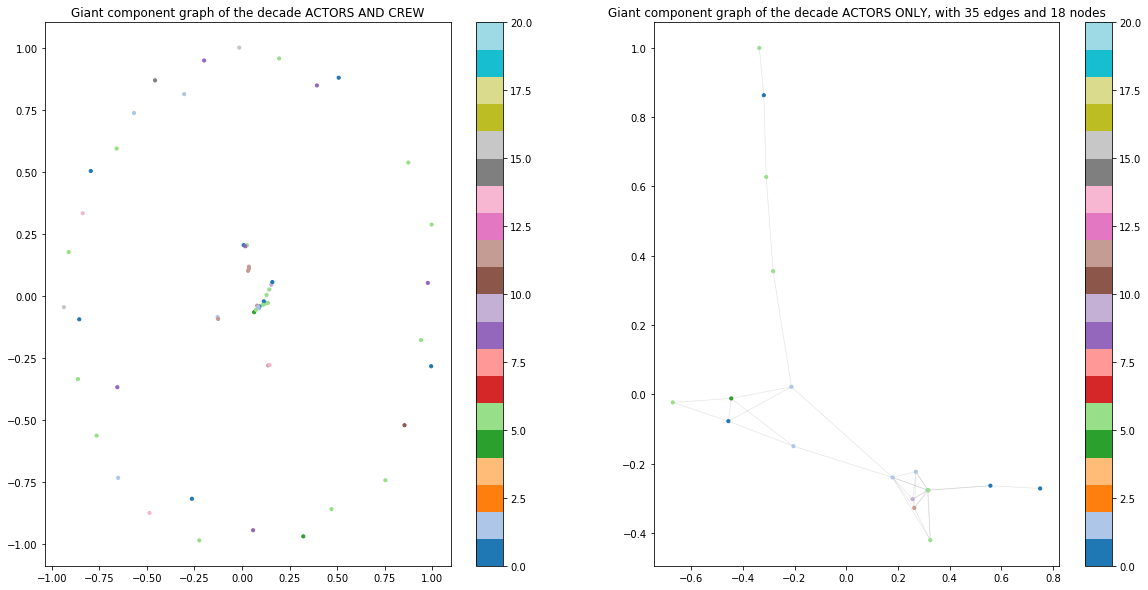

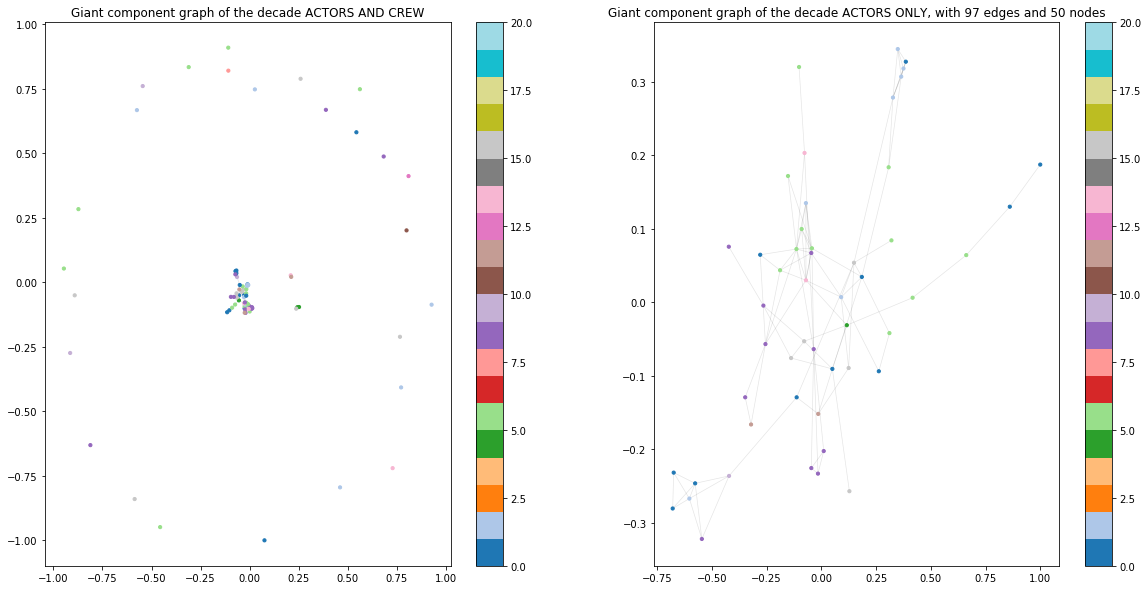

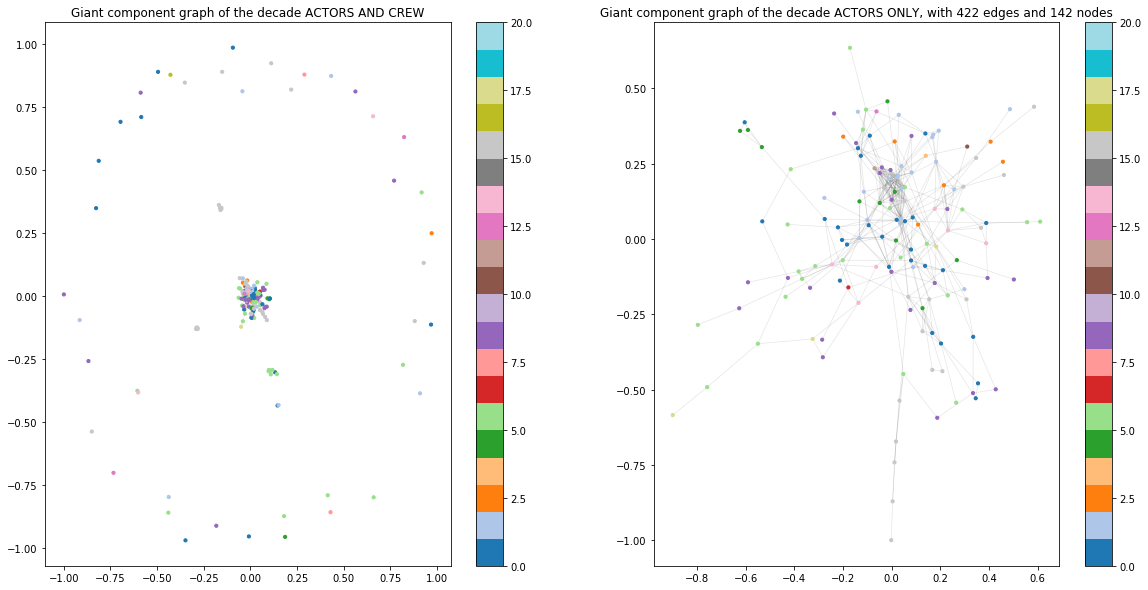

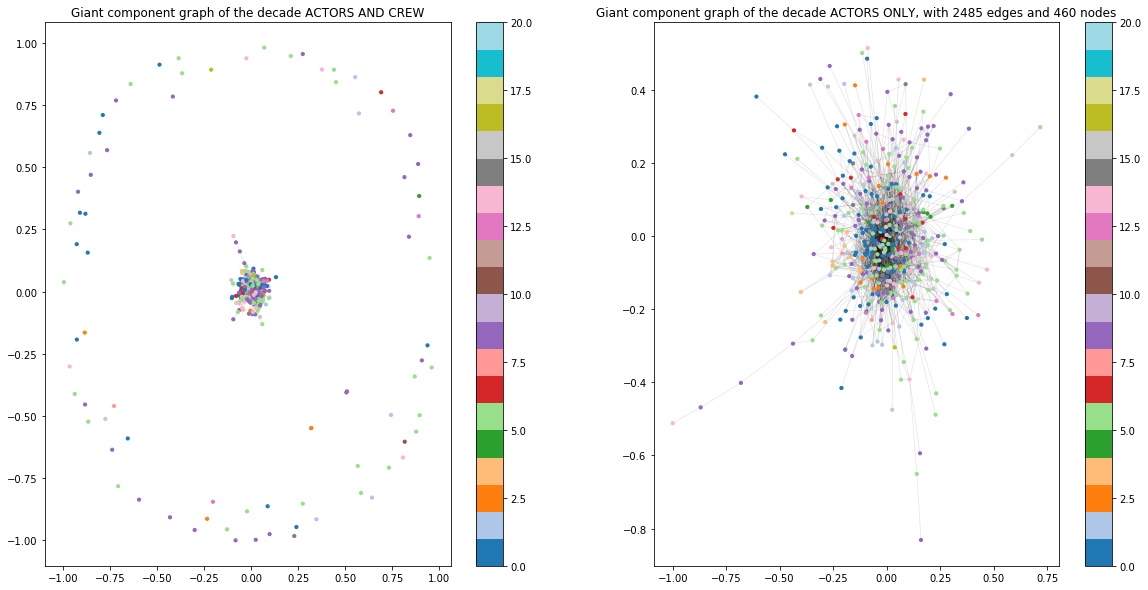

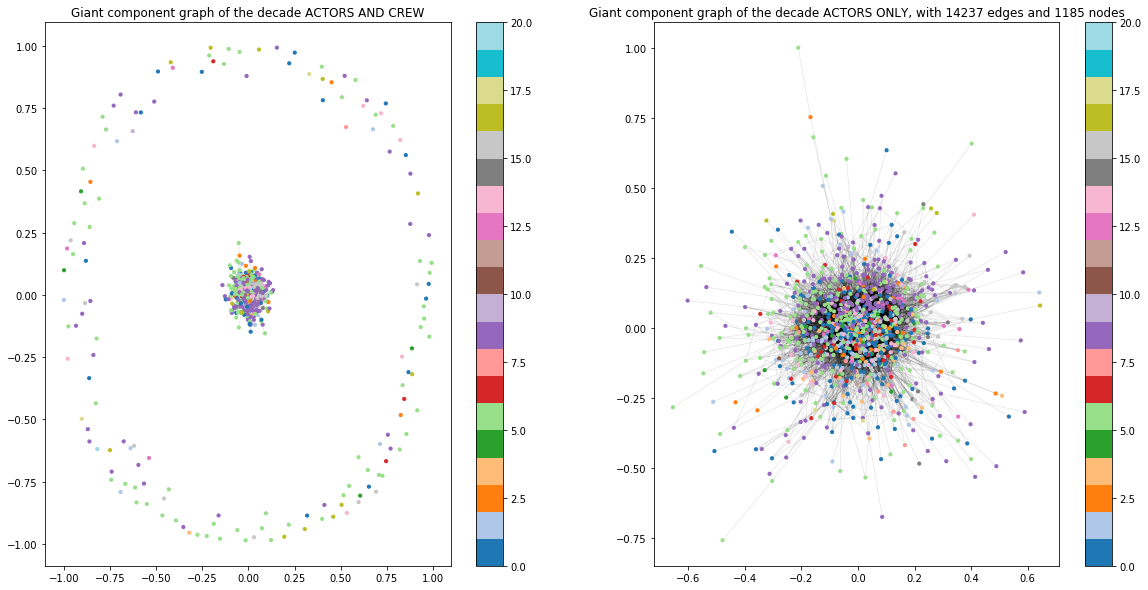

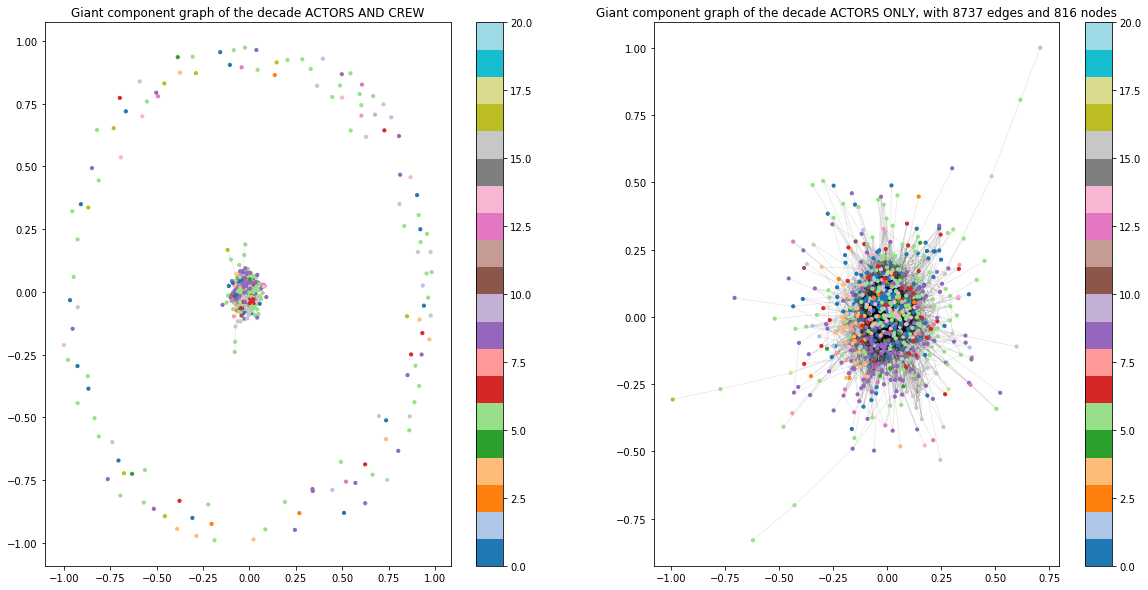

In [20]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS AND CREW')
    plt.colorbar(im);
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);

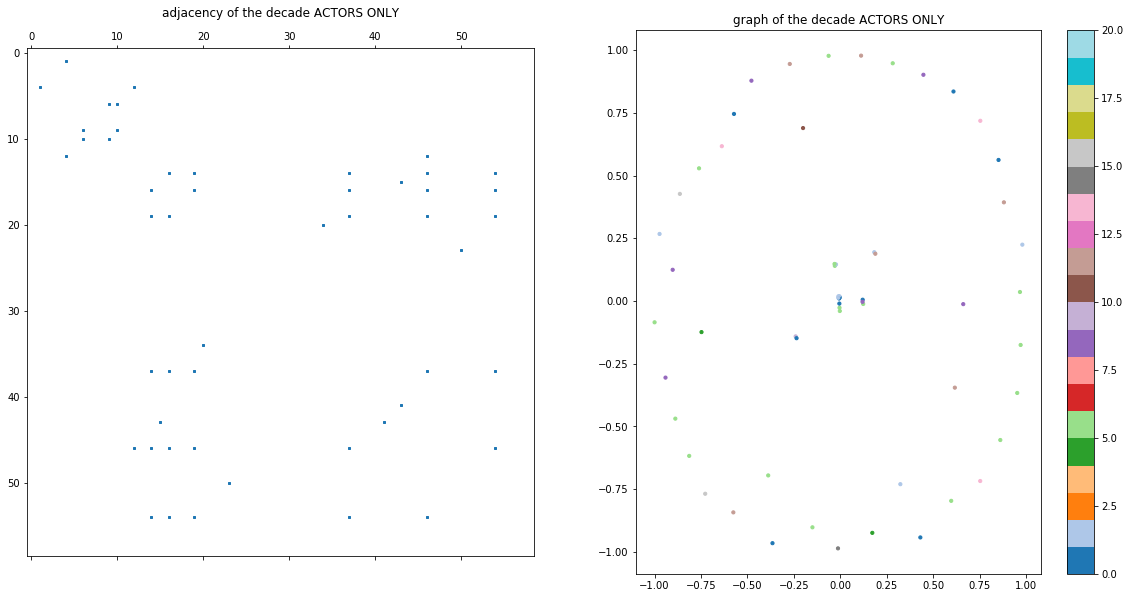

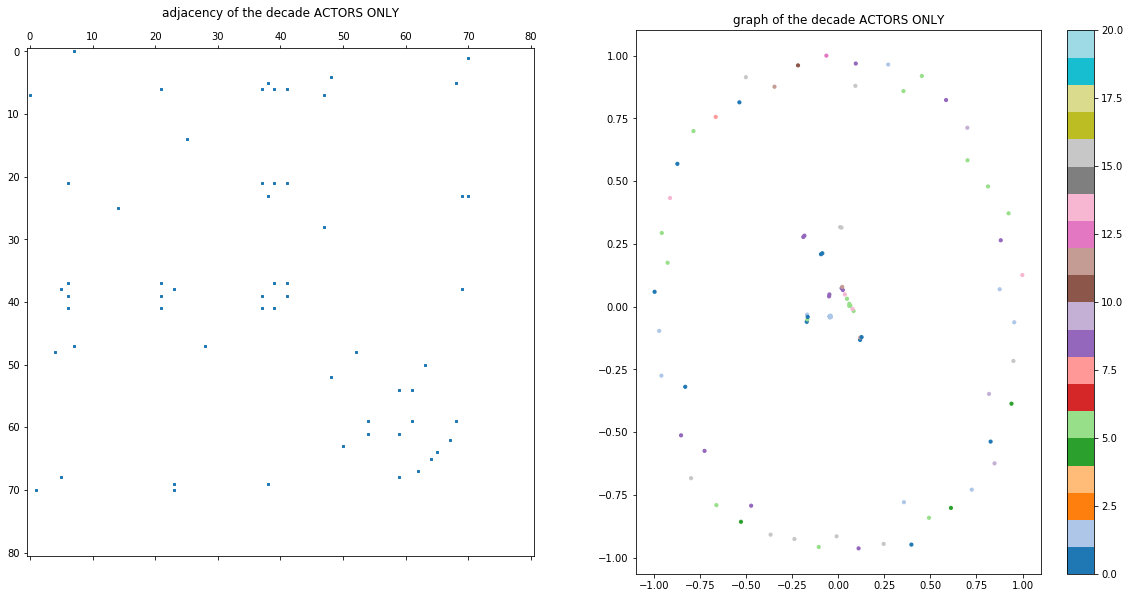

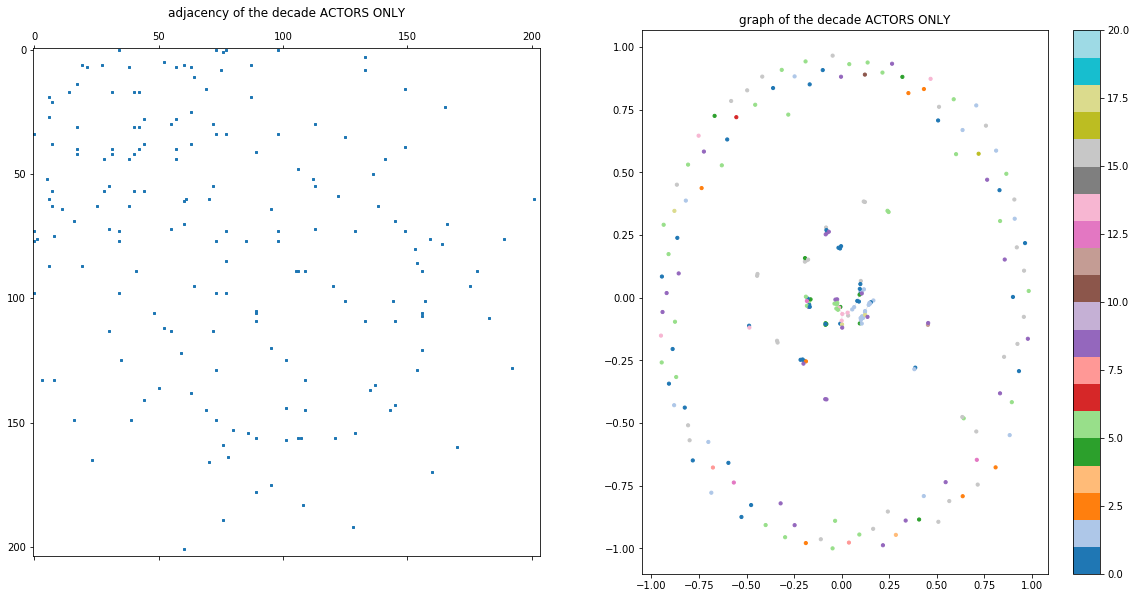

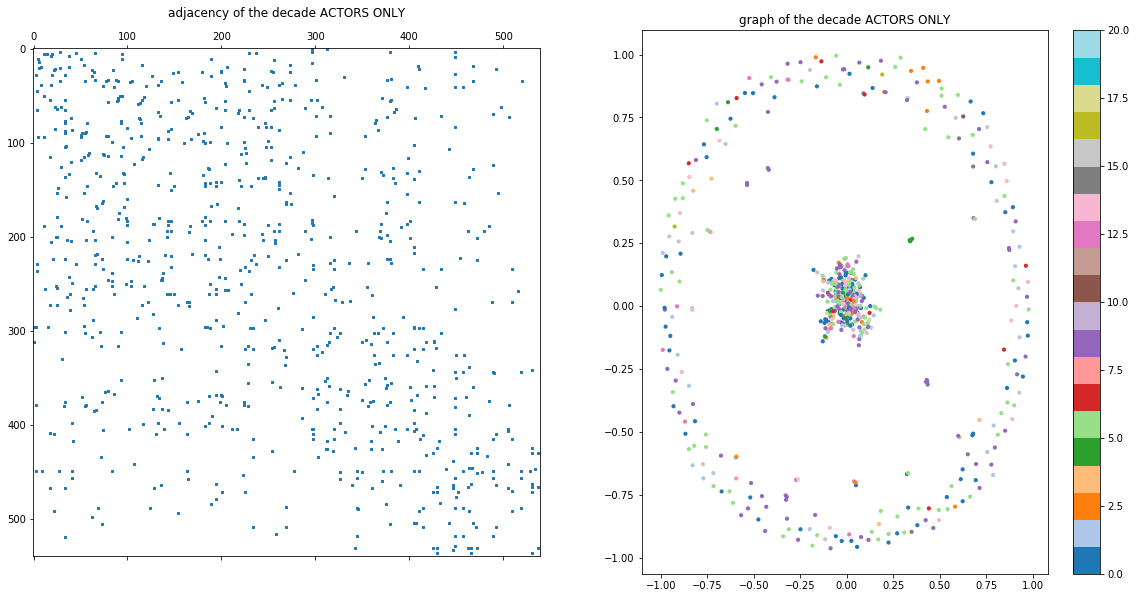

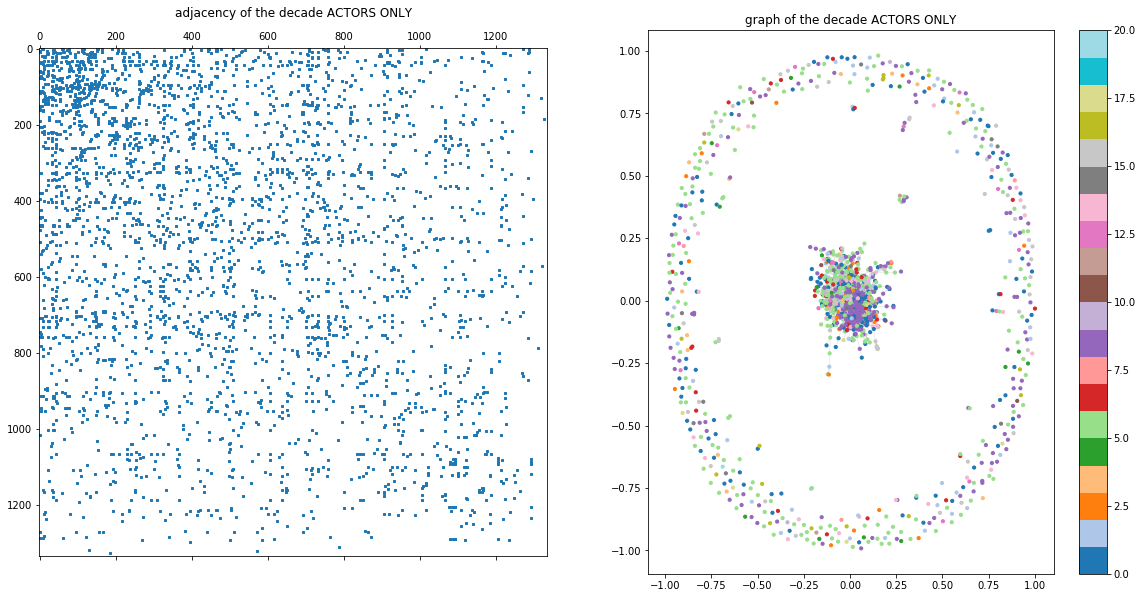

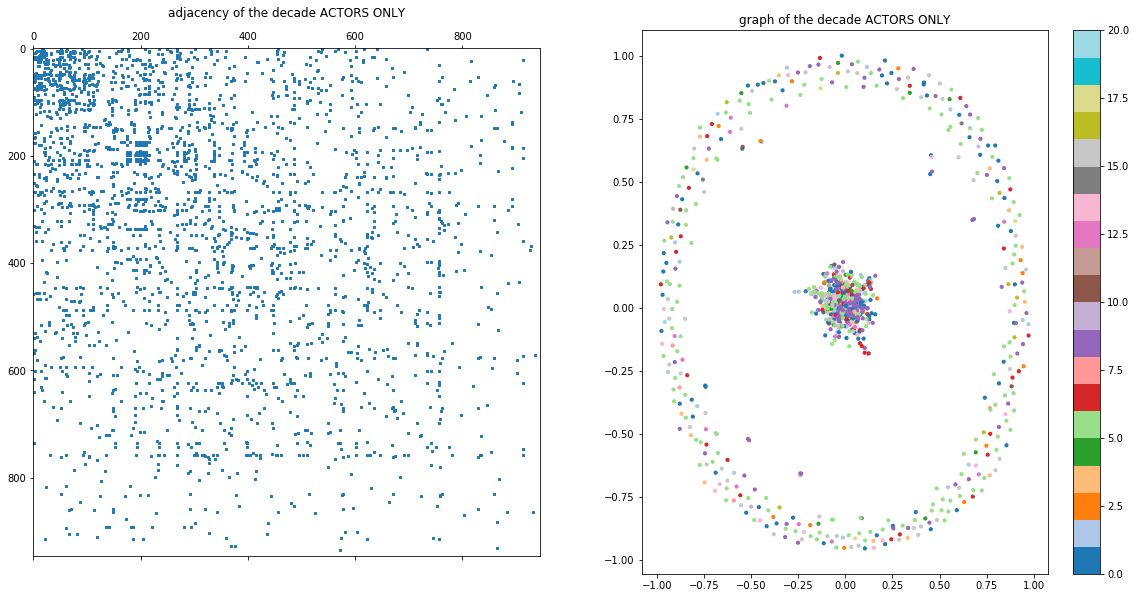

In [21]:
#Ici on fait le graph des films liés par les acteurs selon la décade
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency=np.load('./data/adjacency_actors_only.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS ONLY')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS ONLY')
    plt.colorbar(im);

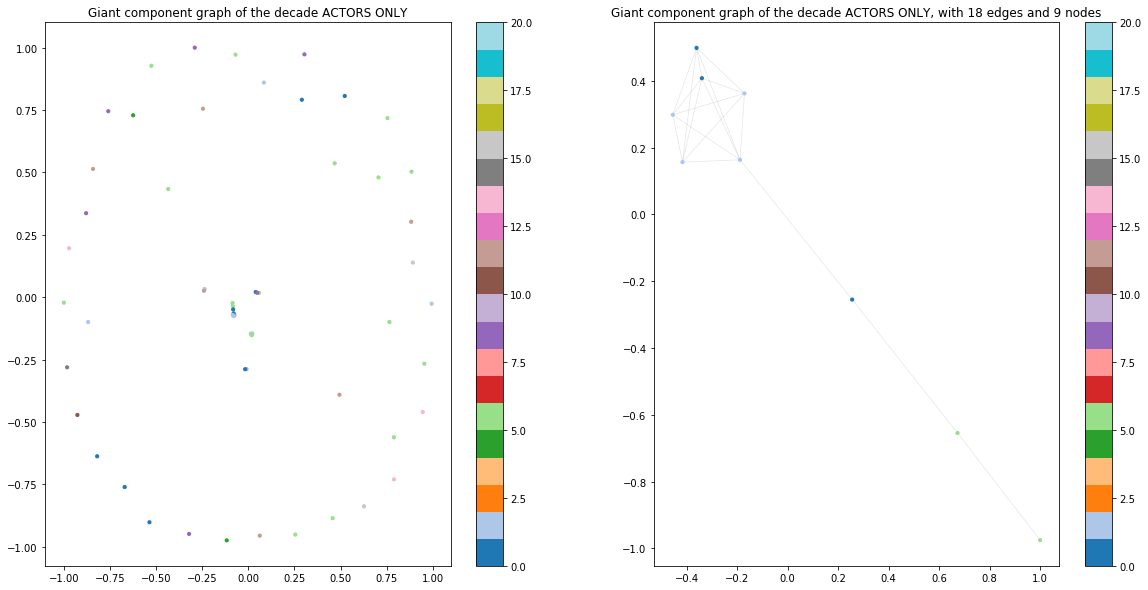

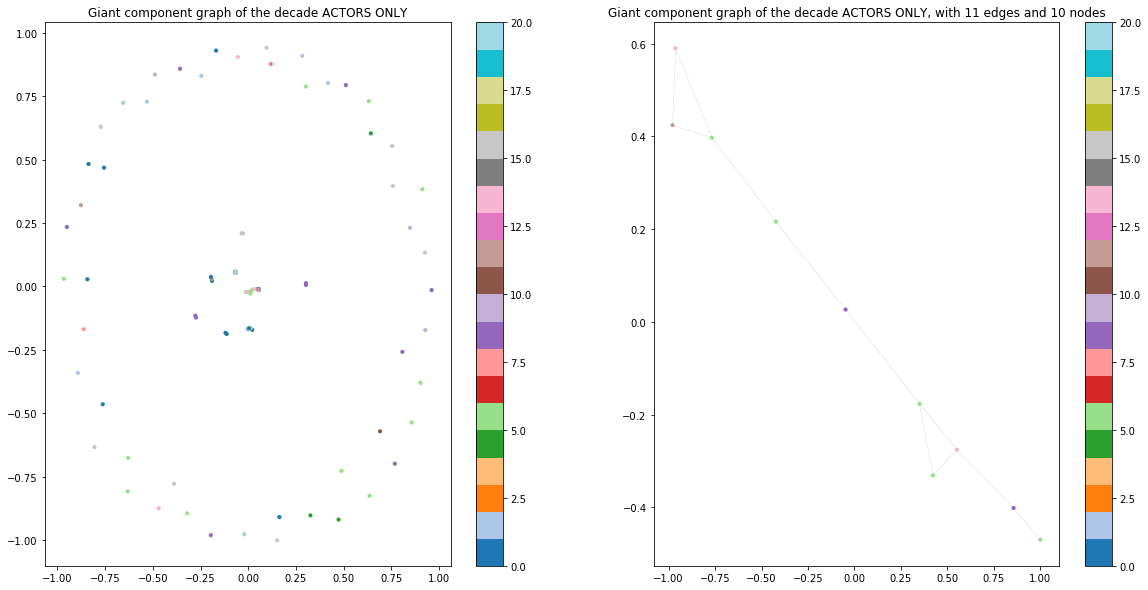

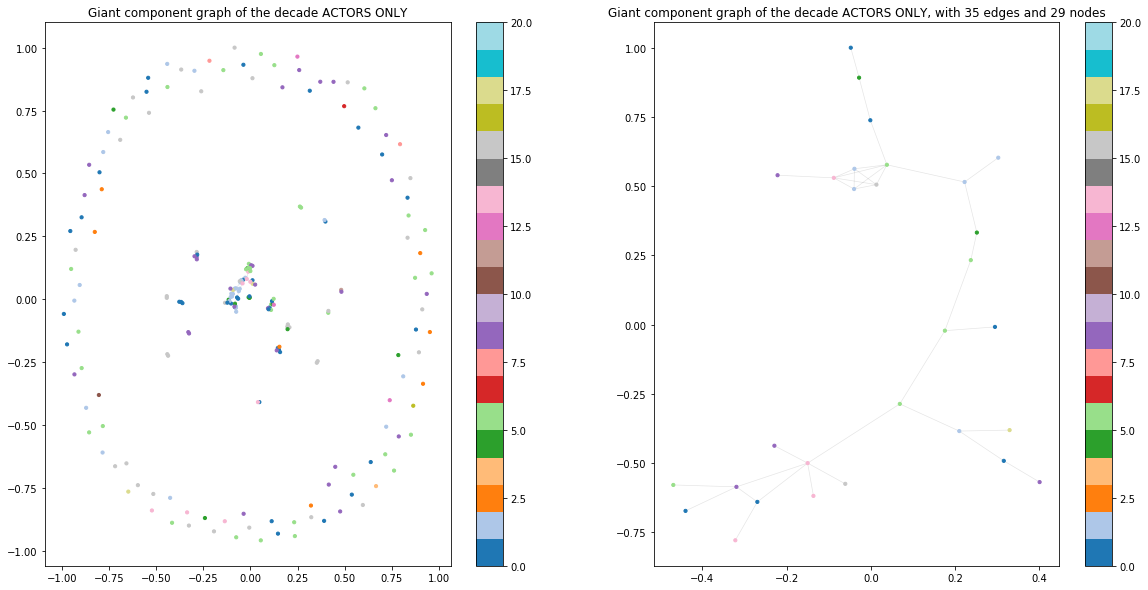

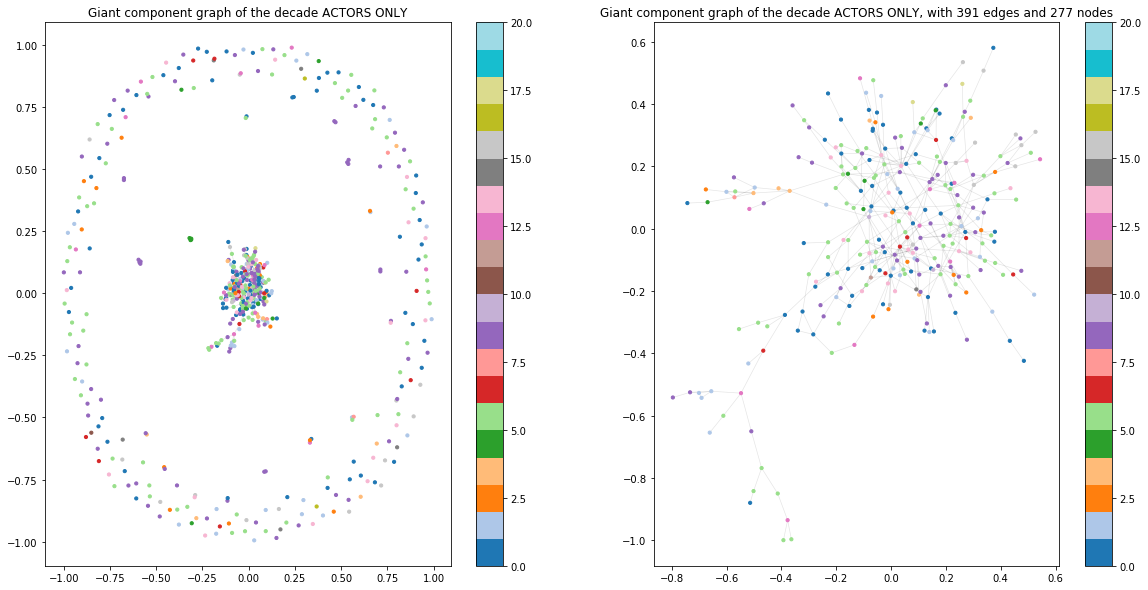

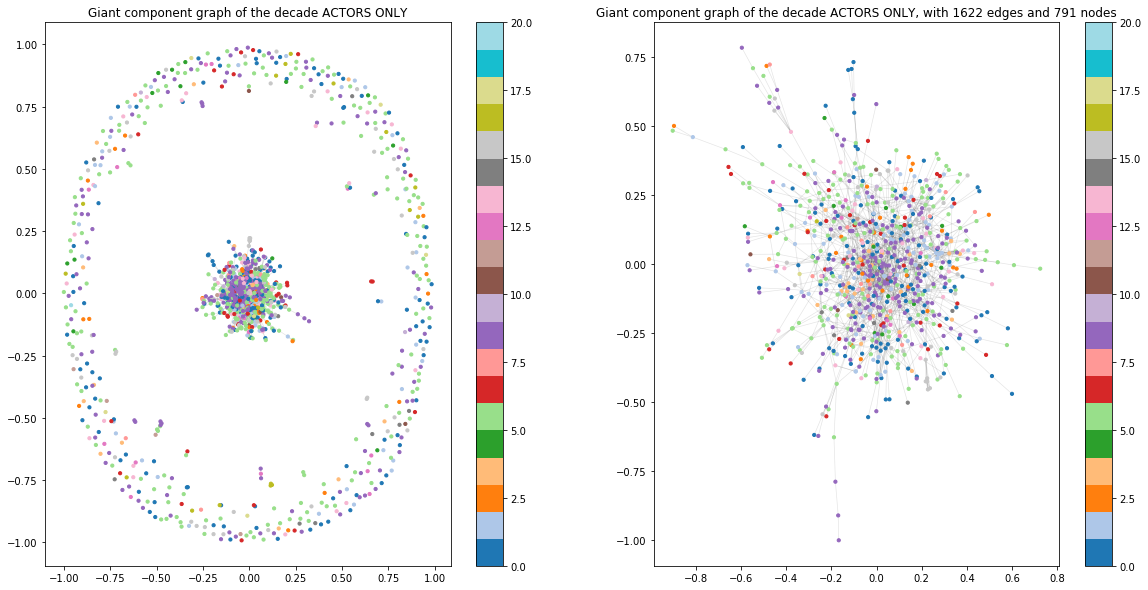

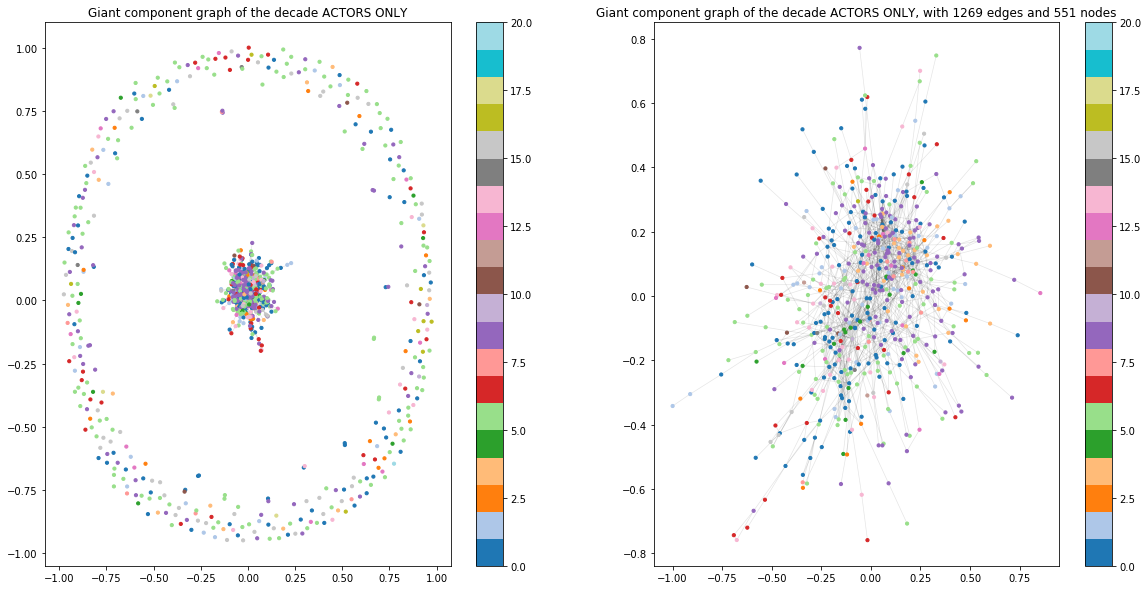

In [22]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY')
    plt.colorbar(im);
    
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20', vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);
    
    
    #normalized_laplacian=nx.normalized_laplacian_matrix(Gc_decade)
    #fiedler=nx.fiedler_vector(Gc_decade)
    #coords = nx.spring_layout(Gc_decade,k=0.03)  # Force-directed layout.
    #e, U = np.linalg.eigh(normalized_laplacian)
    #plt.figure(figsize=(10, 10))
    #plt.subplot(122)
    #im=nx.draw_networkx_nodes(Gc_decade, coords, node_size=10, node_color=fiedler)
    #nx.draw_networkx_edges(Gc_decade, coords, alpha=0.1, width=0.5)
    #plt.title('Fiedler Vector')
    #plt.colorbar(im)
    

2019-01-17 11:41:22,141 | INFO : The budget max = 31115000
2019-01-17 11:41:22,143 | INFO : 862      2000000
1125    31115000
2140    20000000
2170      806948
2192    20000000
Name: budget, dtype: int64
2019-01-17 11:41:22,147 | INFO : The number of nodes is : 59


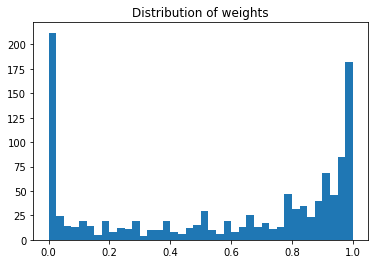

2019-01-17 11:41:22,384 | INFO : The number of edges is : 381
2019-01-17 11:41:22,384 | INFO : Adjacency done !
2019-01-17 11:41:22,421 | INFO : The budget max = 55000000
2019-01-17 11:41:22,423 | INFO : 813     55000000
1243      500000
1367    35000000
1403    35000000
1510    35000000
Name: budget, dtype: int64
2019-01-17 11:41:22,430 | INFO : The number of nodes is : 81


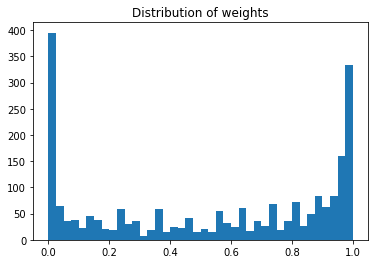

2019-01-17 11:41:22,711 | INFO : The number of edges is : 638
2019-01-17 11:41:22,713 | INFO : Adjacency done !
2019-01-17 11:41:22,778 | INFO : The budget max = 70000000
2019-01-17 11:41:22,782 | INFO : 379    20000000
417     8000000
587    70000000
655     4200000
794    63000000
Name: budget, dtype: int64
2019-01-17 11:41:22,790 | INFO : The number of nodes is : 204


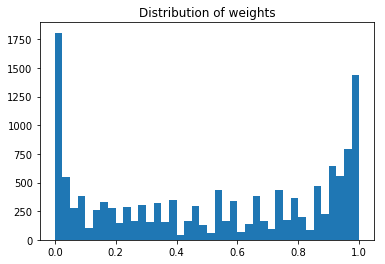

2019-01-17 11:41:23,008 | INFO : The number of edges is : 3426
2019-01-17 11:41:23,010 | INFO : Adjacency done !
2019-01-17 11:41:23,095 | INFO : The budget max = 200000000
2019-01-17 11:41:23,098 | INFO : 25     200000000
70     170000000
75     175000000
149    140000000
164    140000000
Name: budget, dtype: int64
2019-01-17 11:41:23,104 | INFO : The number of nodes is : 540


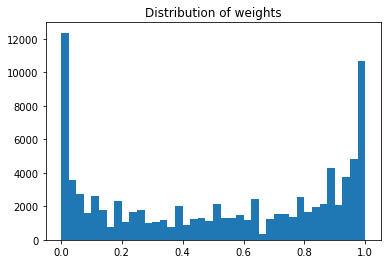

2019-01-17 11:41:23,352 | INFO : The number of edges is : 21338
2019-01-17 11:41:23,352 | INFO : Adjacency done !
2019-01-17 11:41:23,655 | INFO : The budget max = 300000000
2019-01-17 11:41:23,657 | INFO : 0     237000000
1     300000000
5     258000000
8     250000000
10    270000000
Name: budget, dtype: int64
2019-01-17 11:41:23,668 | INFO : The number of nodes is : 1335


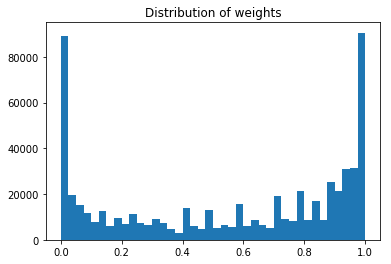

2019-01-17 11:41:23,946 | INFO : The number of edges is : 174114
2019-01-17 11:41:23,947 | INFO : Adjacency done !
2019-01-17 11:41:25,416 | INFO : The budget max = 380000000
2019-01-17 11:41:25,419 | INFO : 2    245000000
3    250000000
4    260000000
6    260000000
7    280000000
Name: budget, dtype: int64
2019-01-17 11:41:25,428 | INFO : The number of nodes is : 946


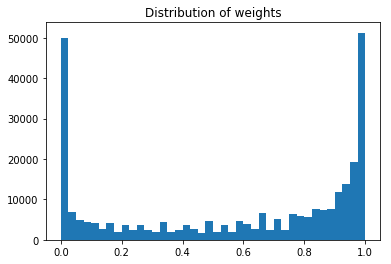

2019-01-17 11:41:25,681 | INFO : The number of edges is : 96272
2019-01-17 11:41:25,682 | INFO : Adjacency done !


In [23]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
adjacenciesGenreFilteredByYears = [] # NEW CODE
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    genreAdjacency = genre_graph.make_genre_adjacency(moviesData); # NEW CODE
    adjacenciesGenreFilteredByYears.append(genreAdjacency) # NEW CODE
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [24]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

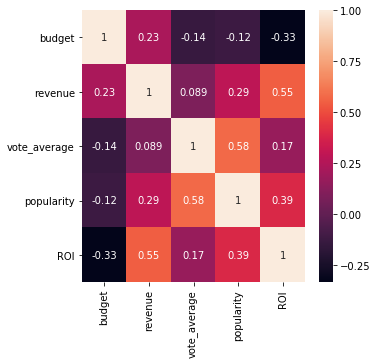

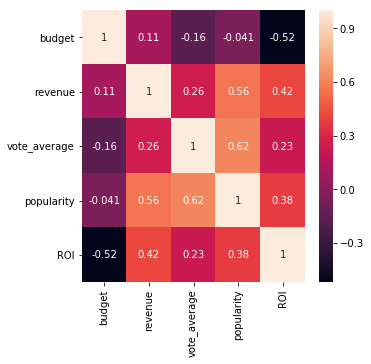

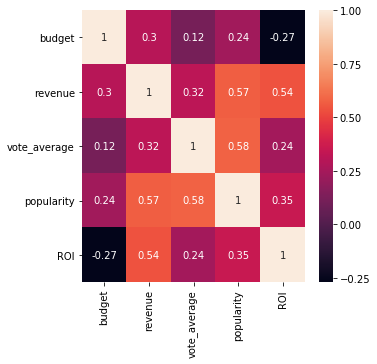

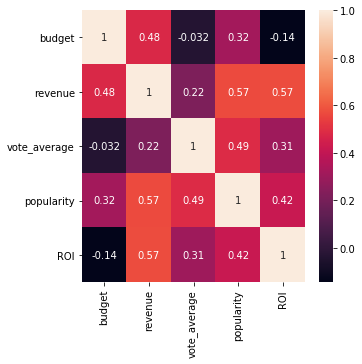

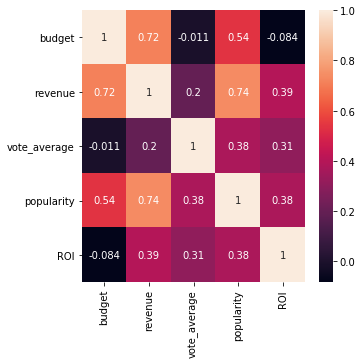

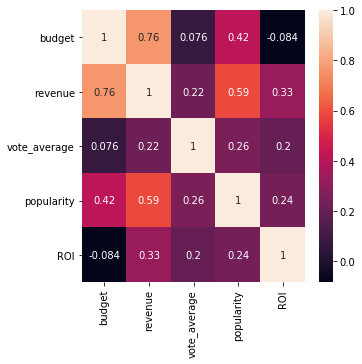

In [25]:
#find the correlation between parameters
for i in range(len(graphsFilteredByYears)):
    plt.figure(figsize=(5, 5))
    data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity','ROI']]
    sns.heatmap(data=data.corr(),annot=True)

In [31]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    #CoordsSpringFilteredByYears.append(nx.spring_layout((nx.from_numpy_matrix(adjacenciesGenreFilteredByYears[i])).subgraph(Gc),k=0.03))# NEW CODE
    
    i = i+1

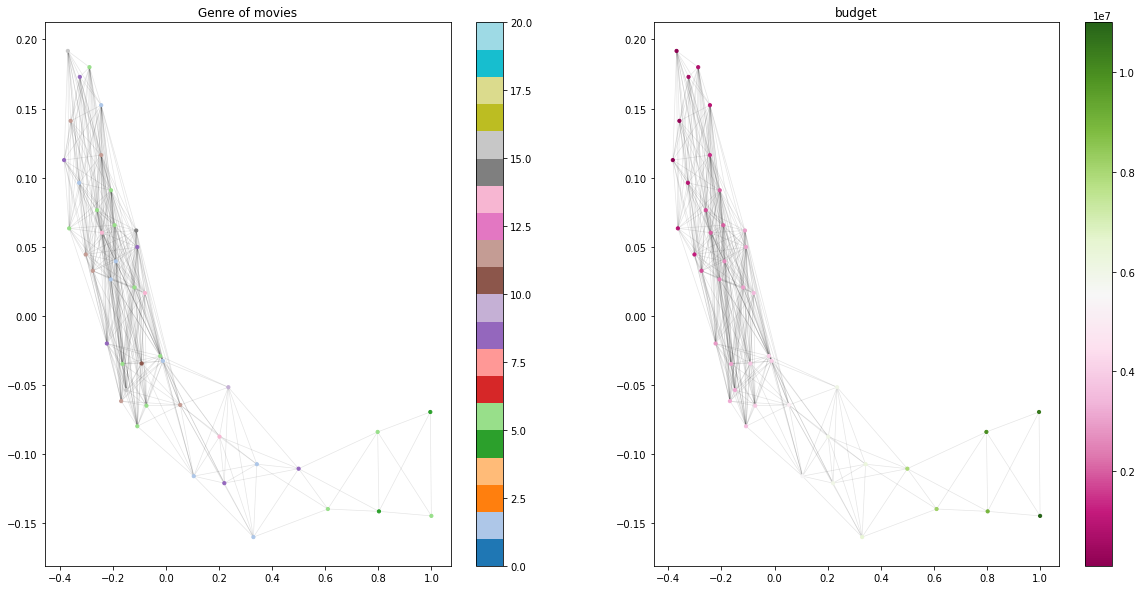

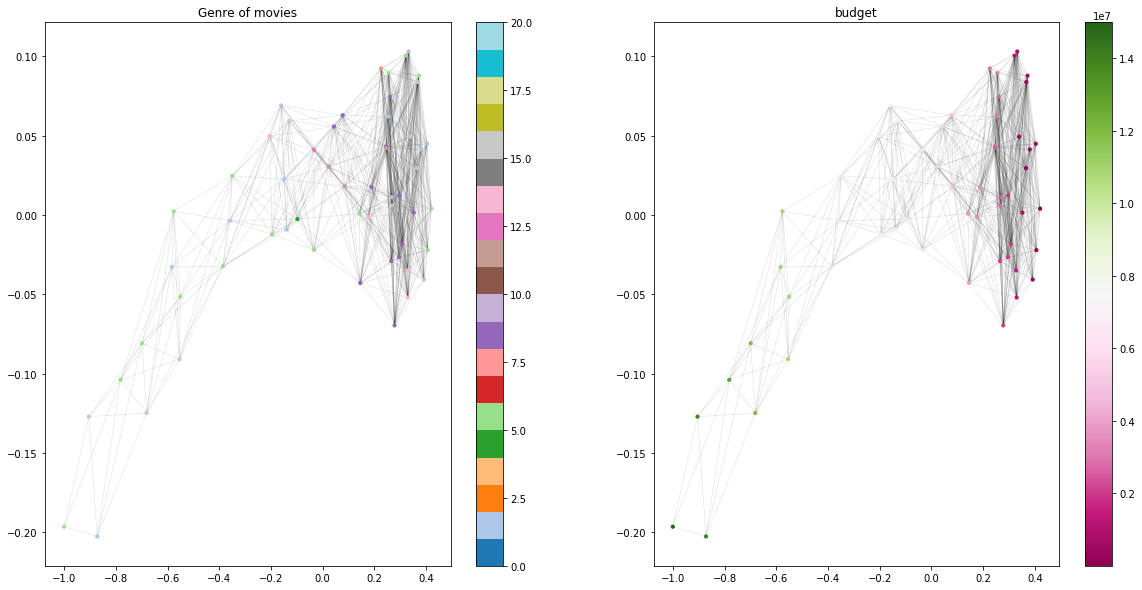

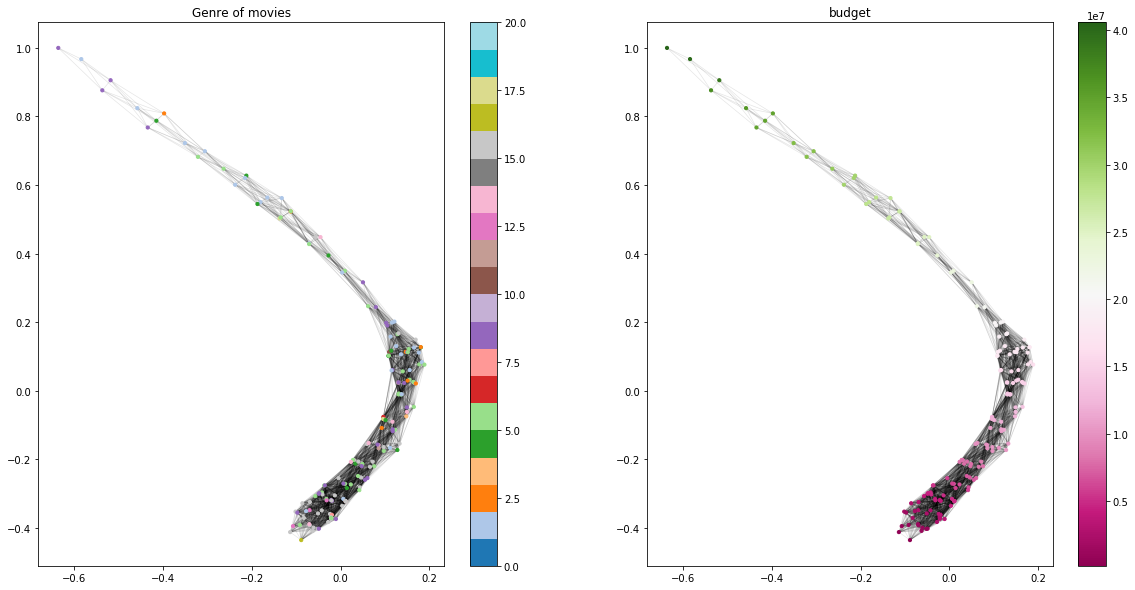

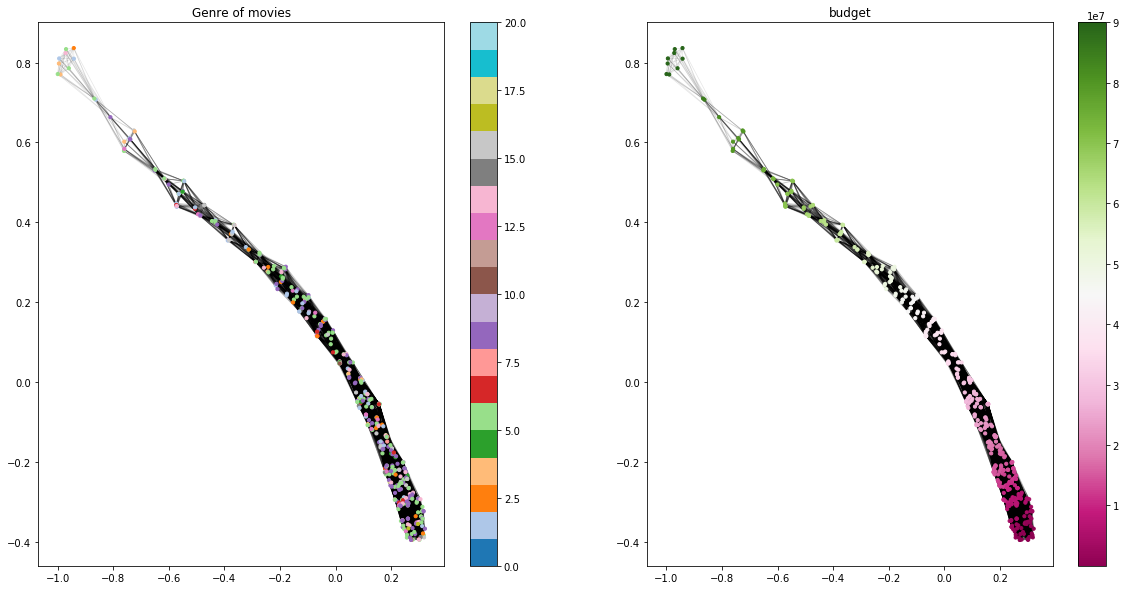

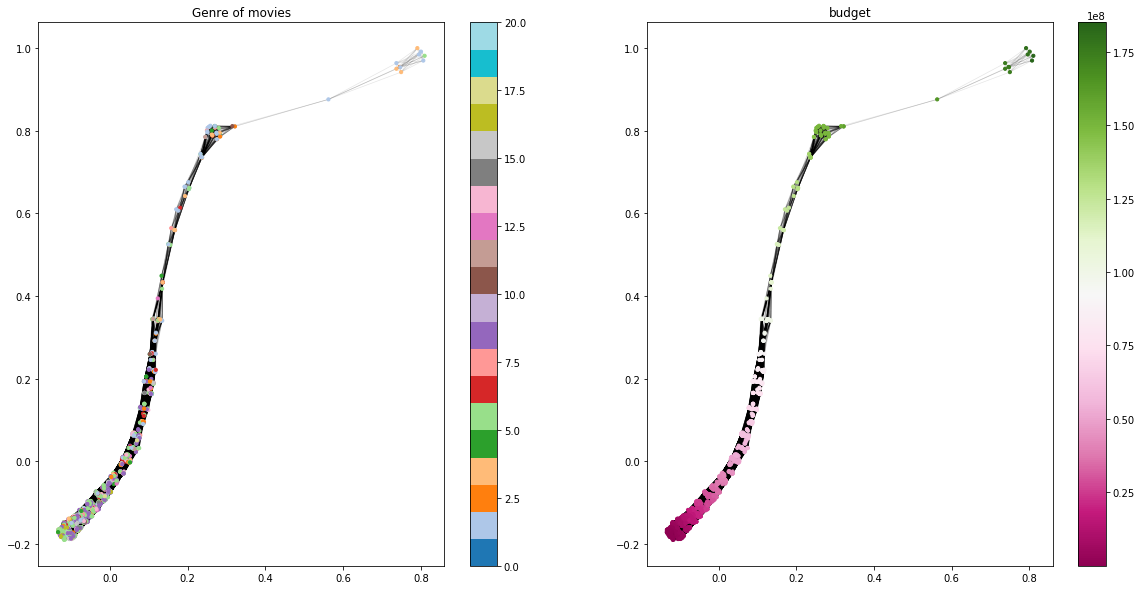

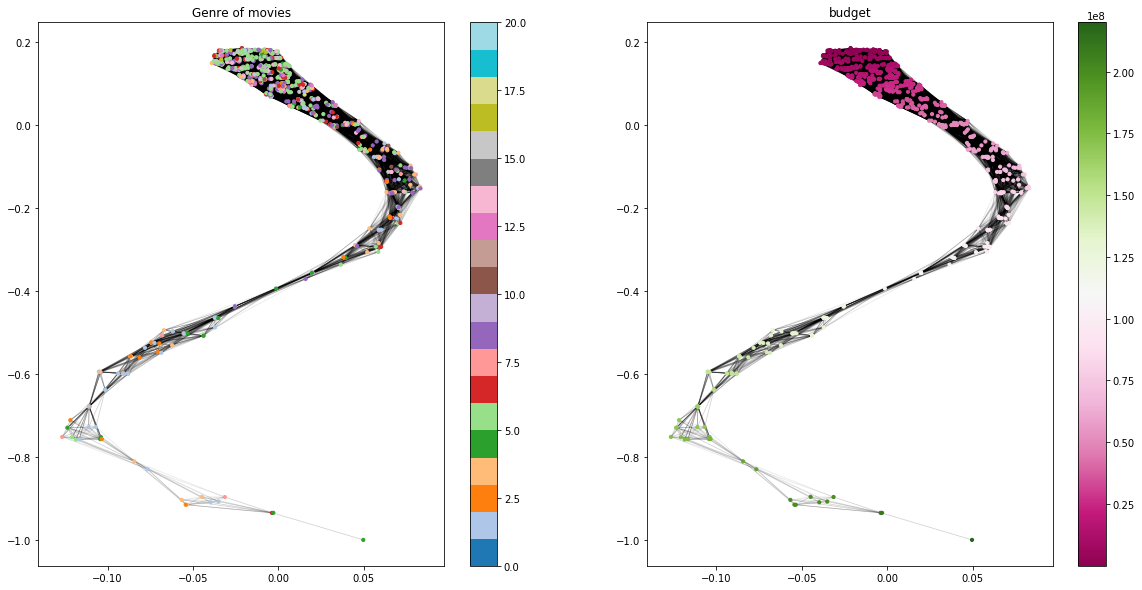

In [32]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('budget')
    plt.colorbar(im);
        
    i=i+1
    

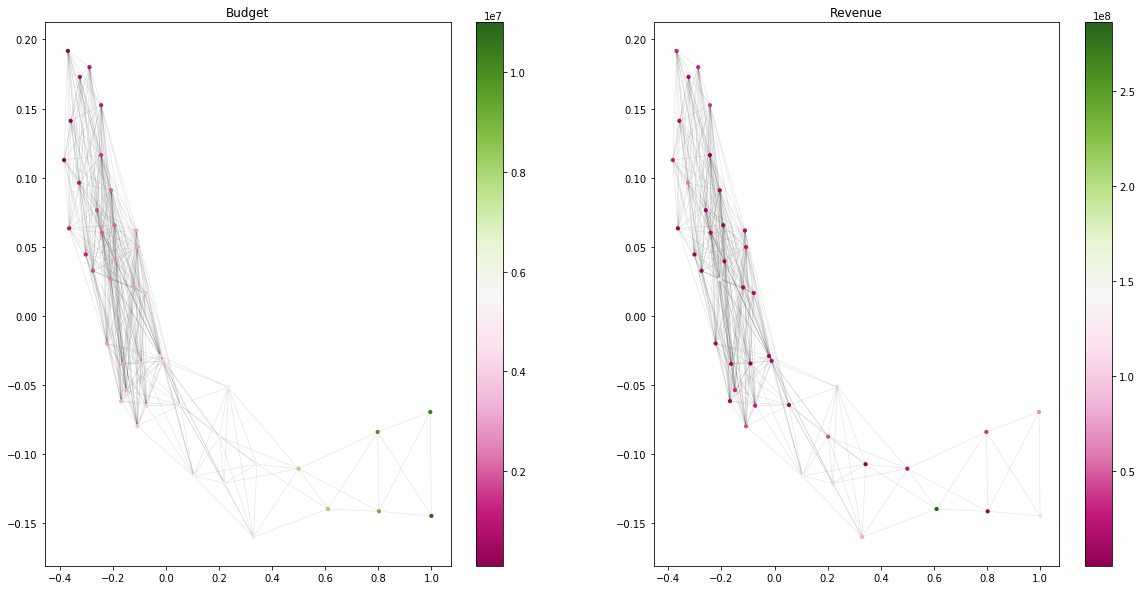

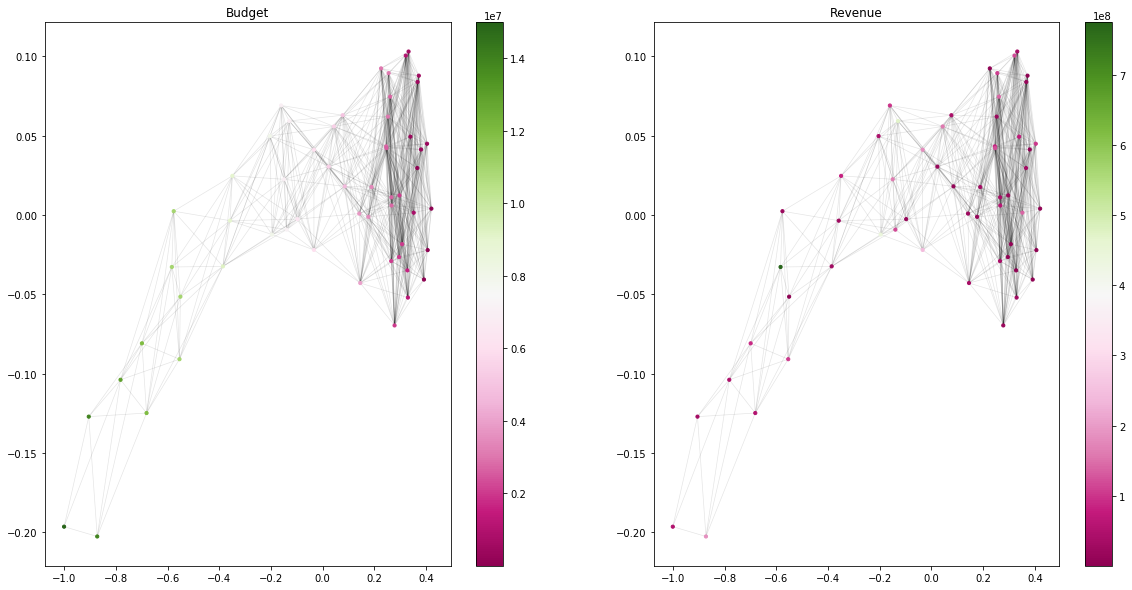

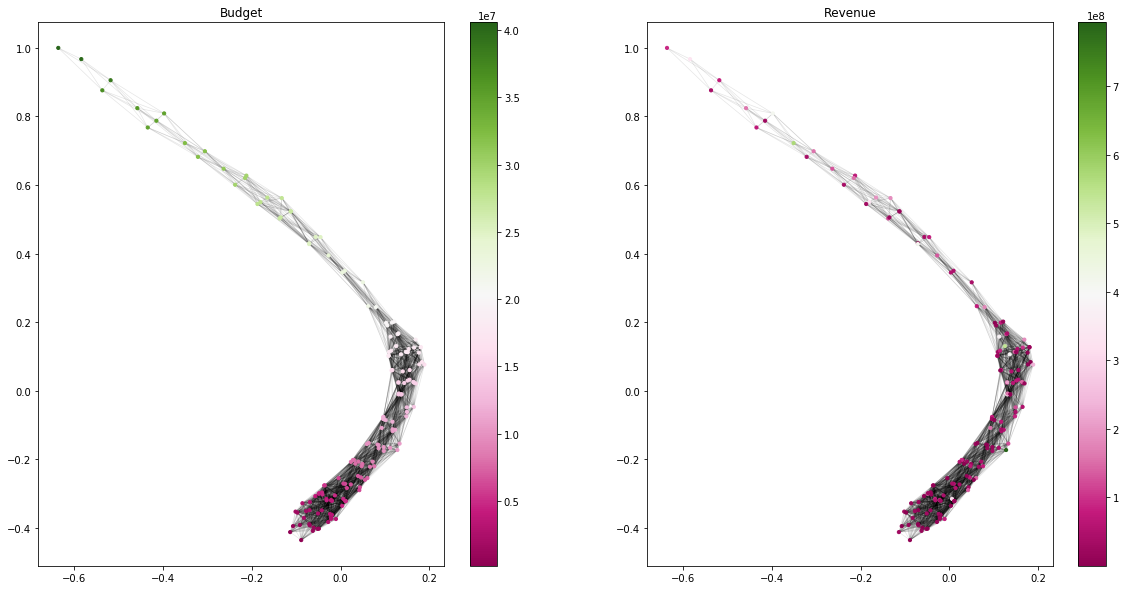

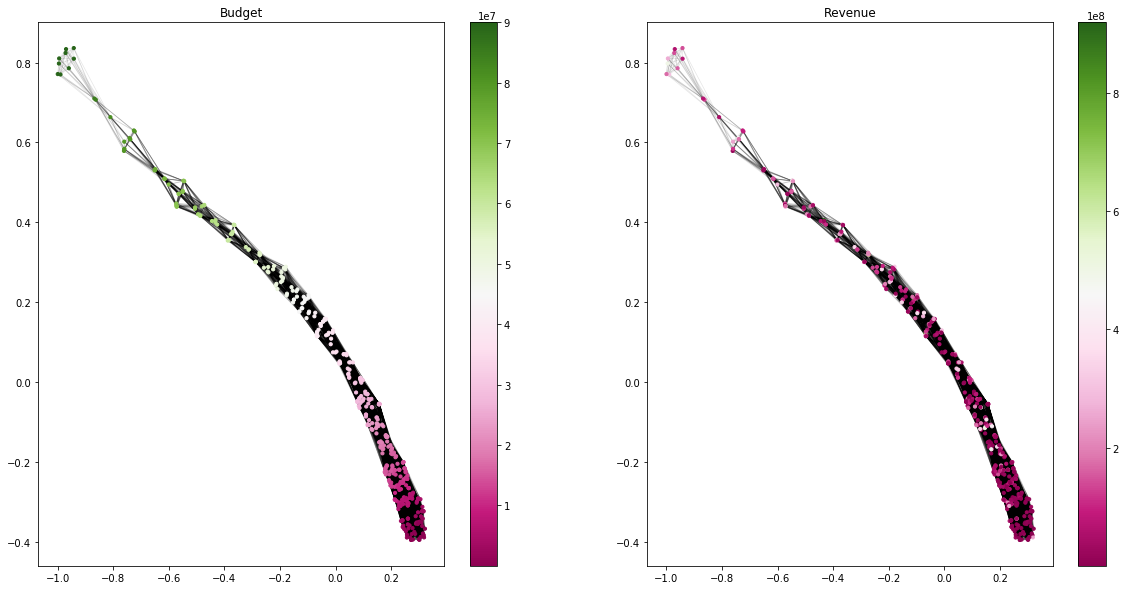

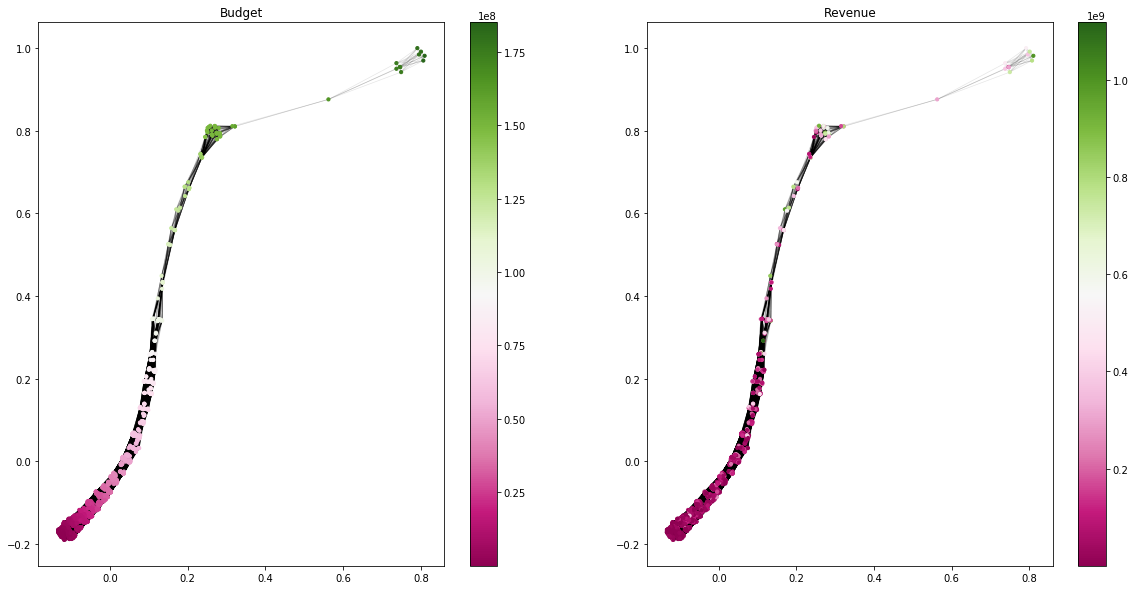

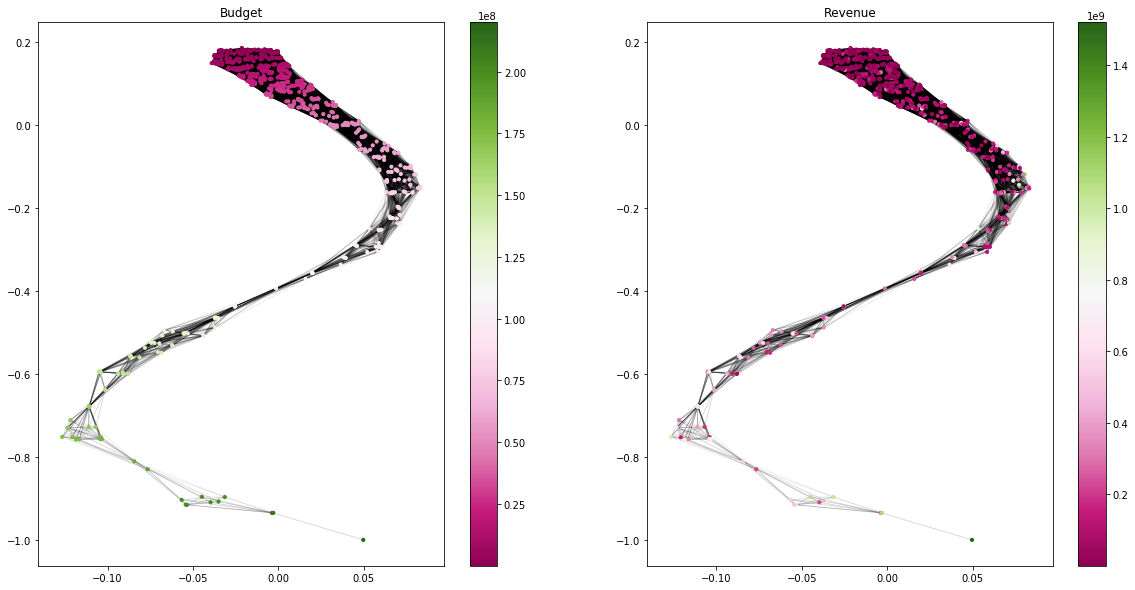

In [33]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

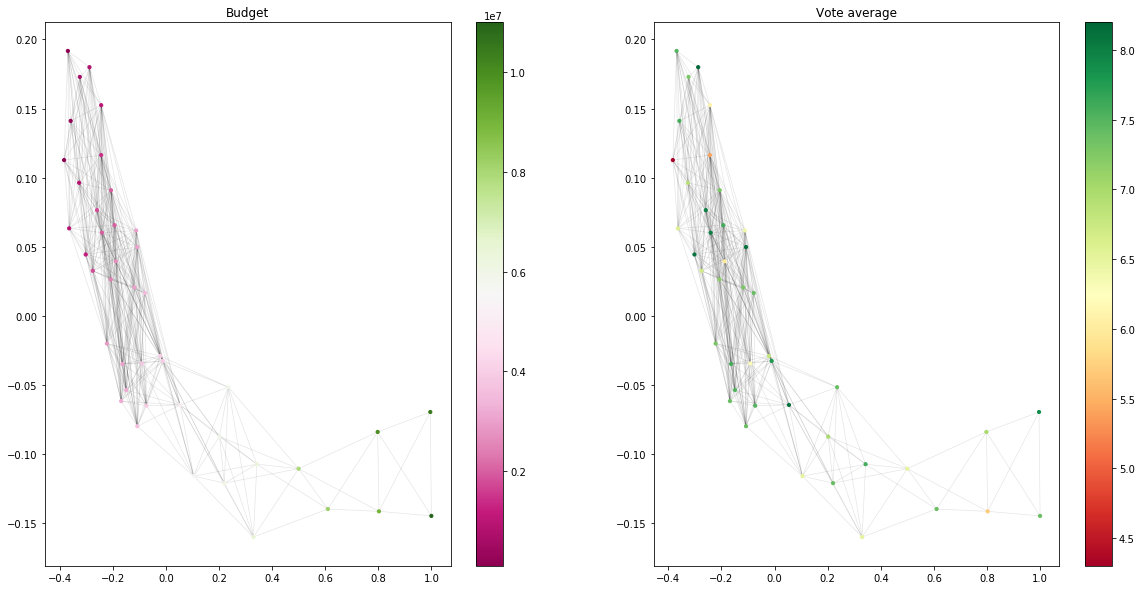

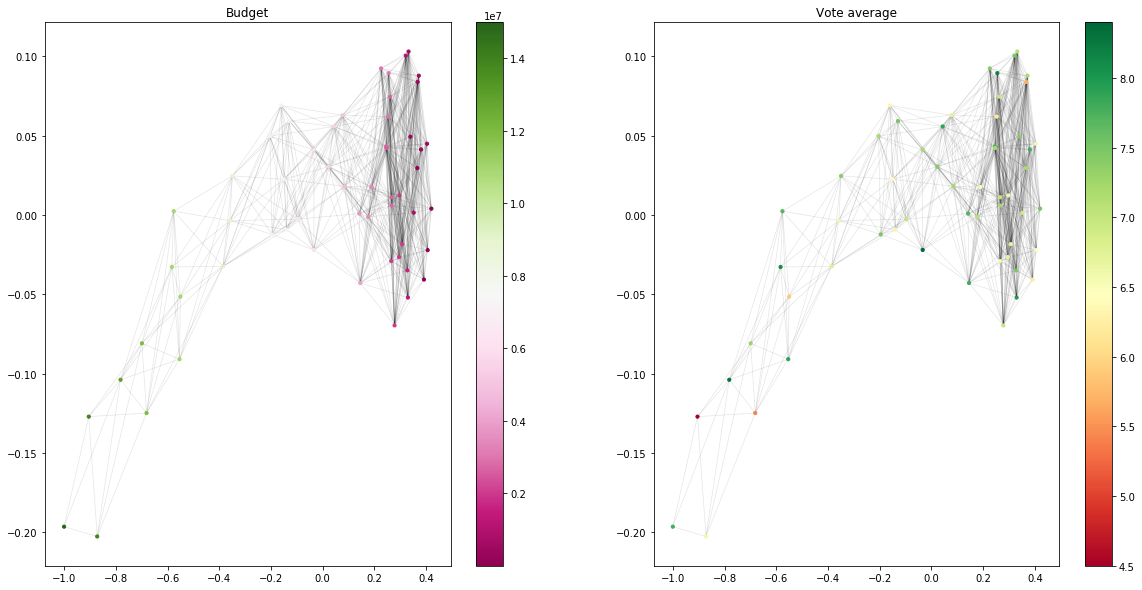

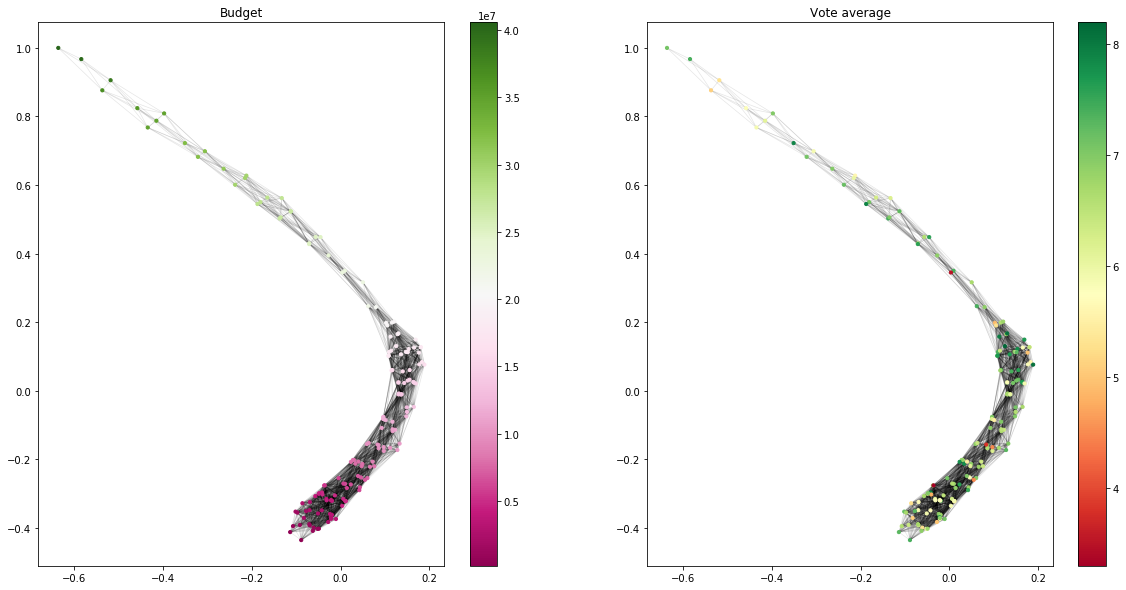

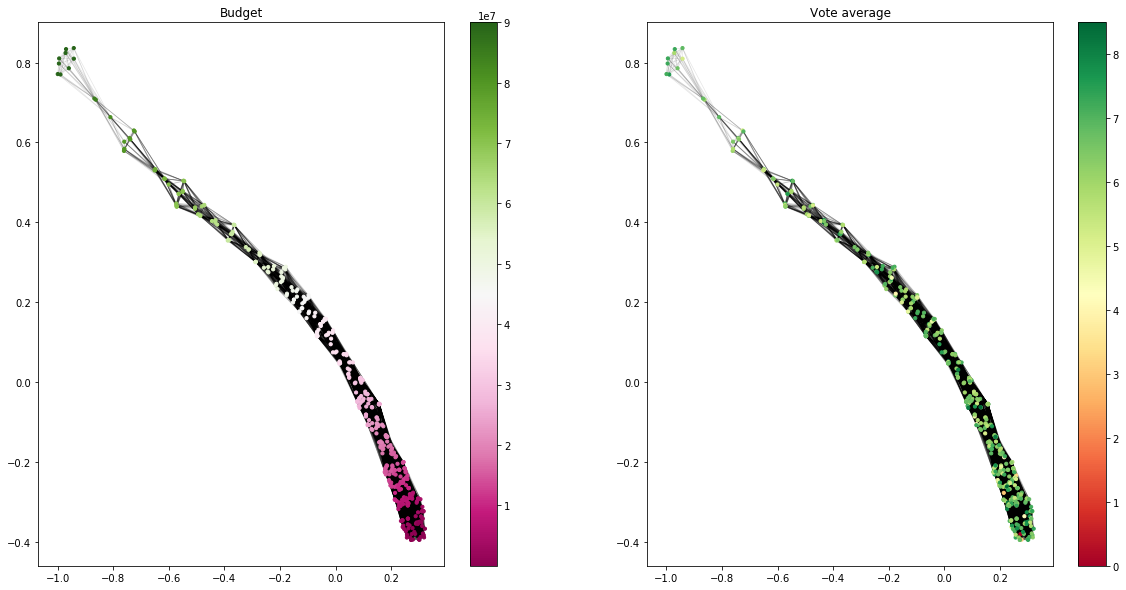

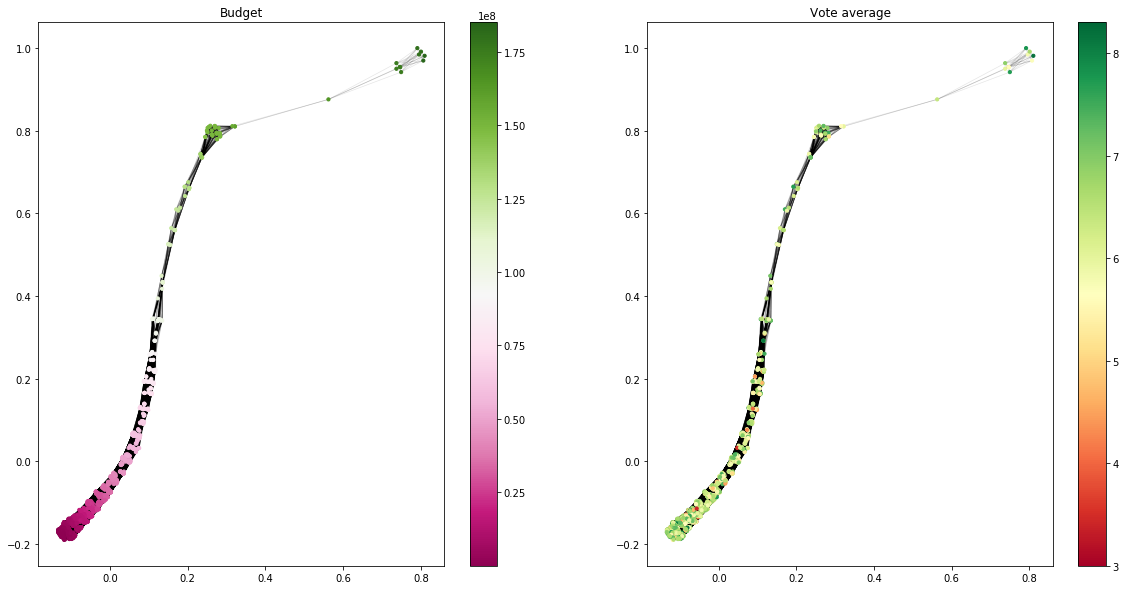

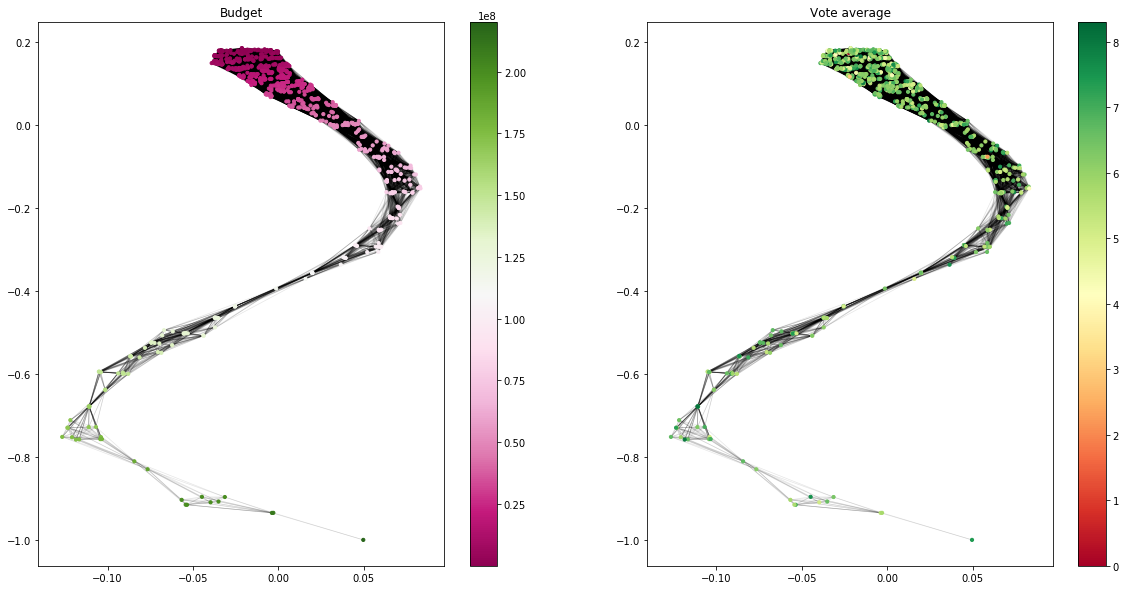

In [34]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

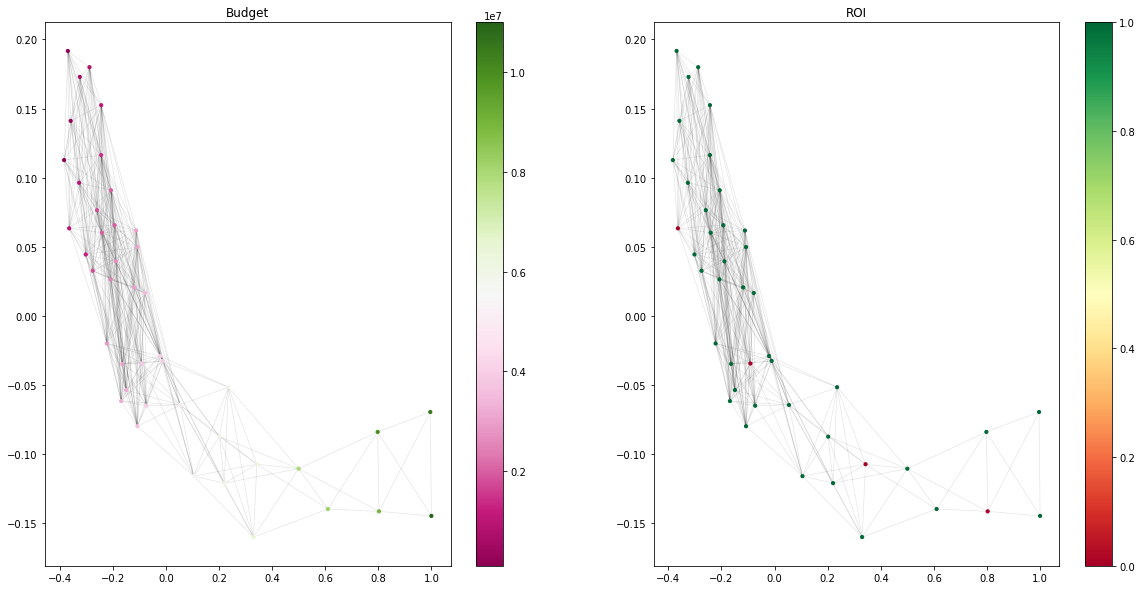

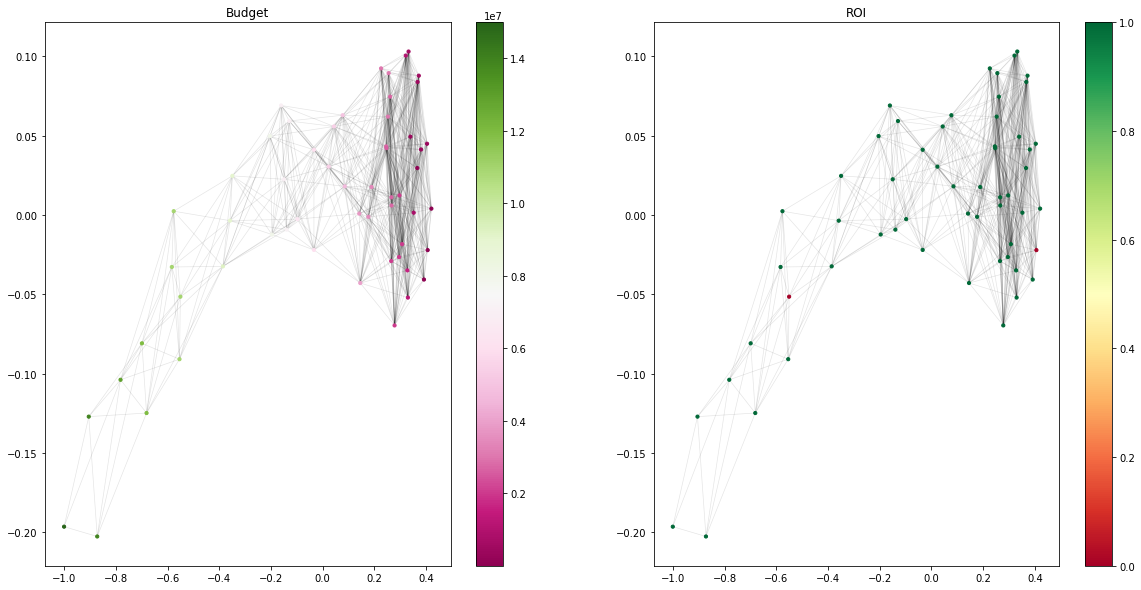

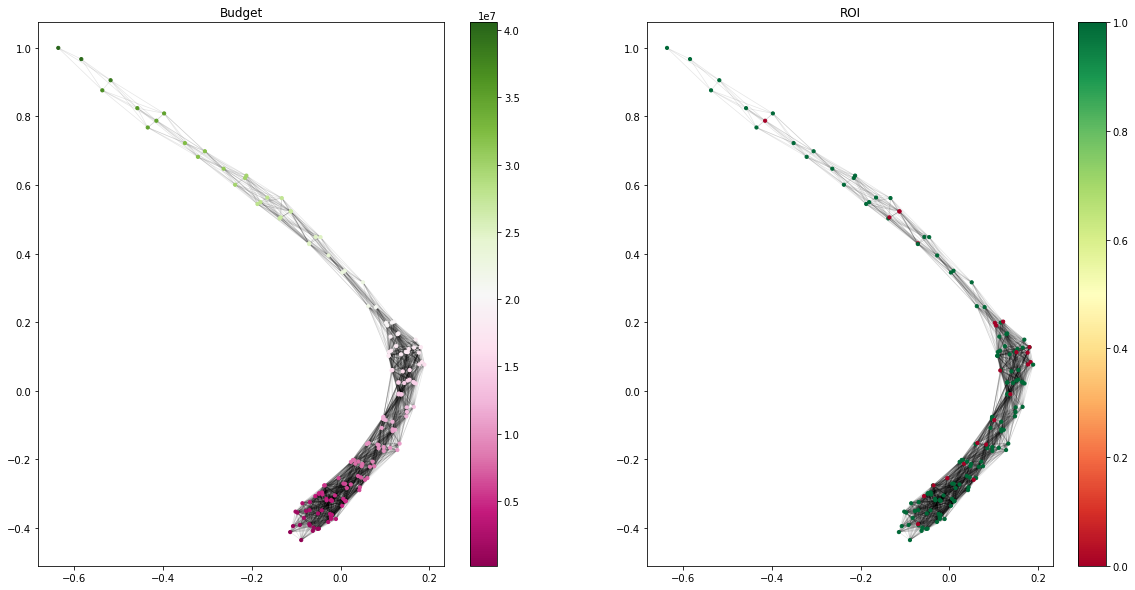

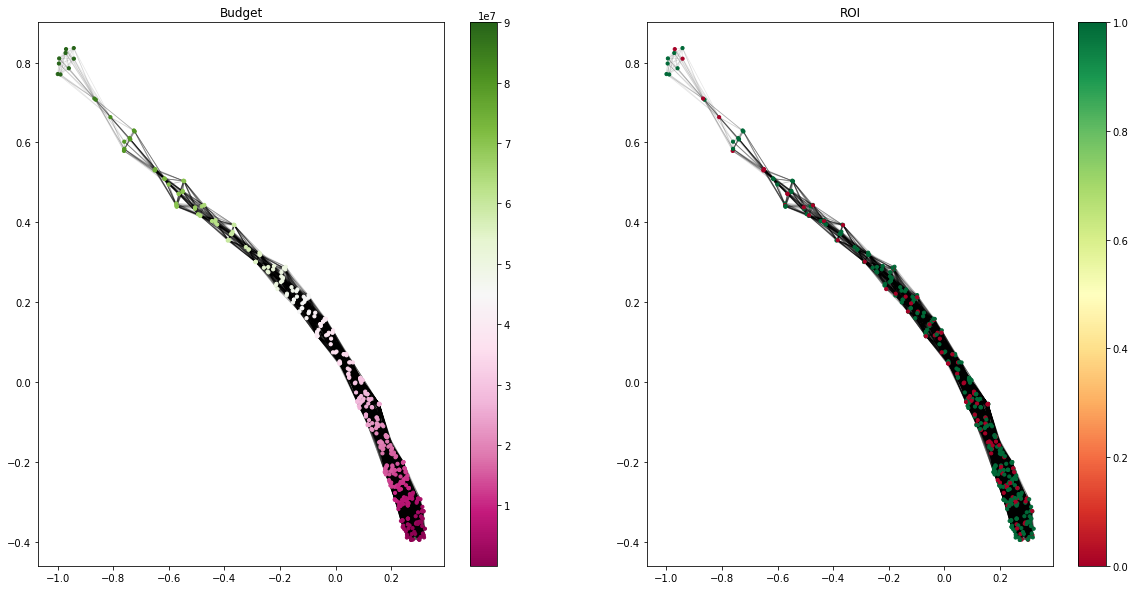

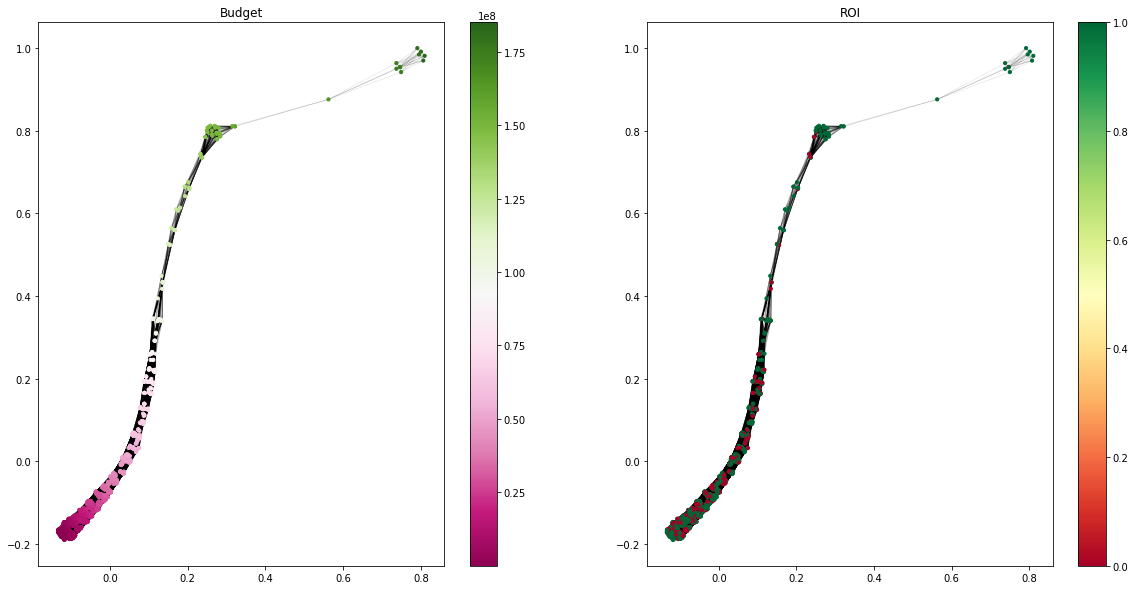

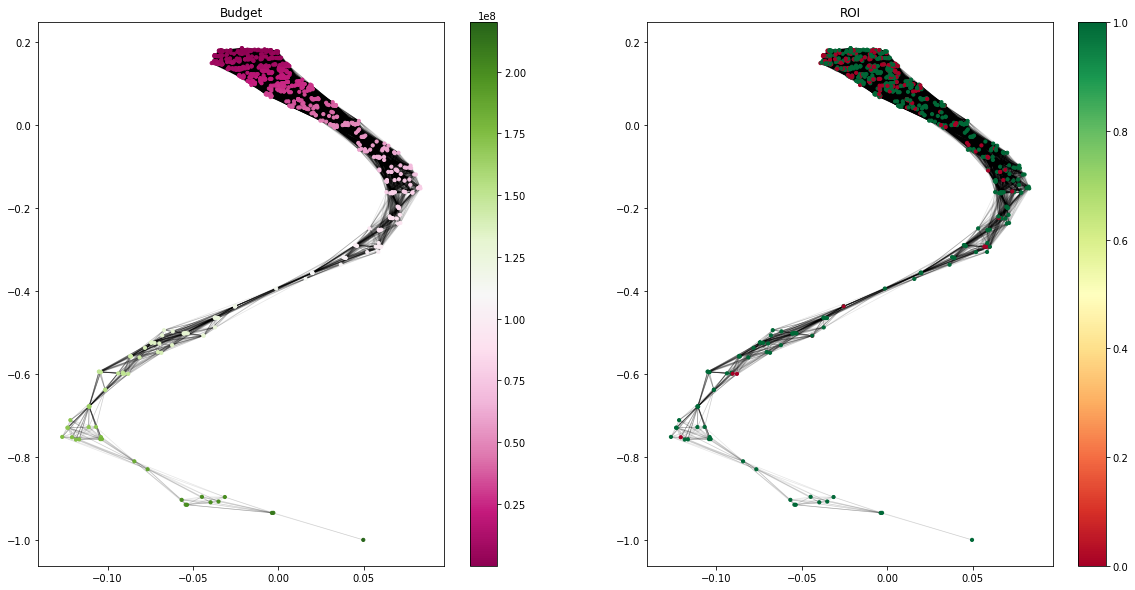

In [35]:
#SUCCESS OF A MOVIE IF THE ROI>1 ? --> plot the success 
#on peut essayer de voir à quel point le success rate est "smooth" sur différents graphs --> 
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['ROI'].iloc[np.sort(nx.nodes(G))]
    labels[labels<0]=0
    labels[labels>0]=1
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('ROI')
    plt.colorbar(im);
        
    i=i+1